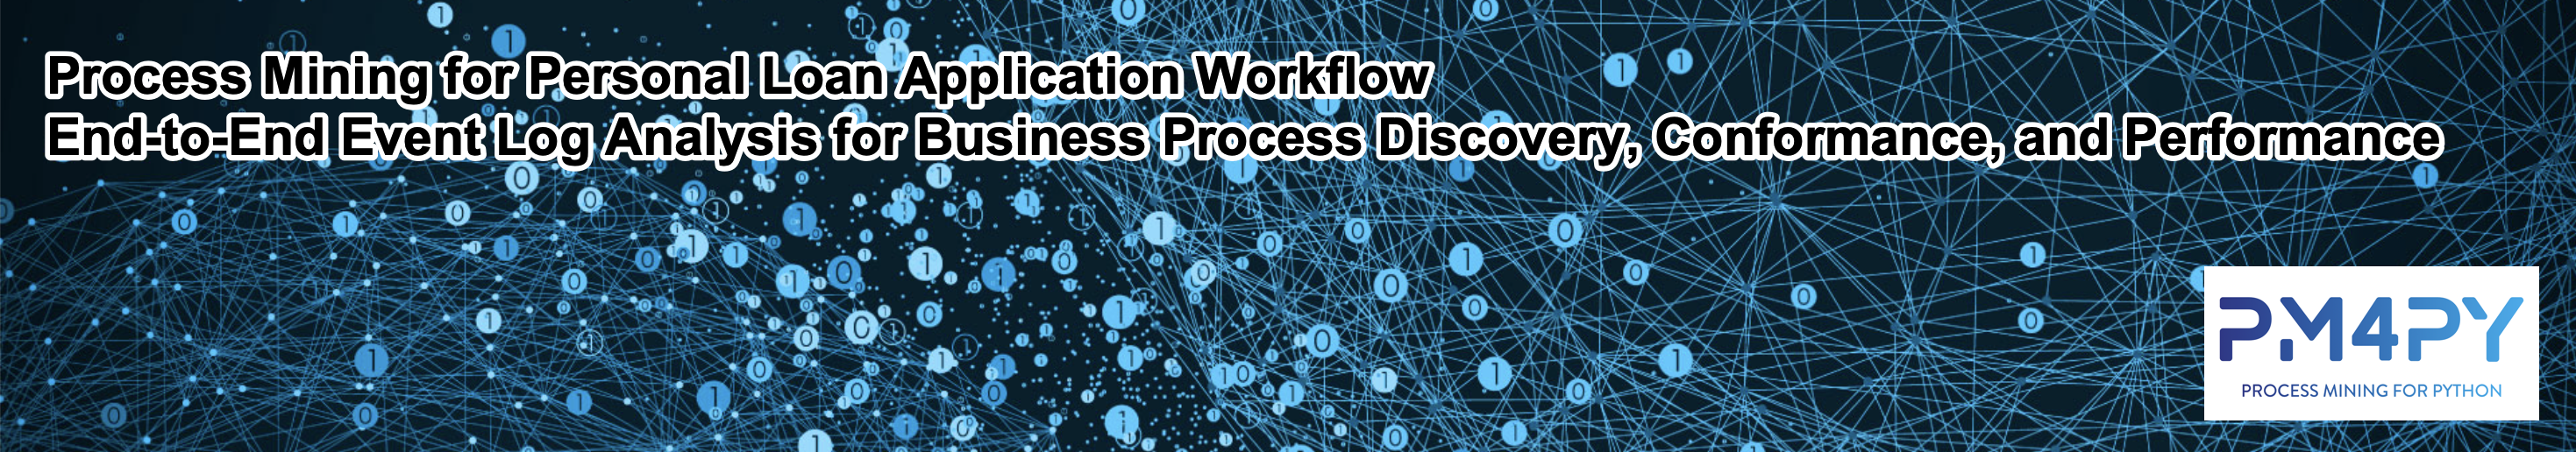

# Process Mining on Personal Loan Event Log

## 1. Introduction

This project applies a full process mining workflow to real-world event log data from a financial institution’s **personal loan application process**. It covers key stages:

- Submission  
- Verification and validation  
- Approval or rejection  
- Contract finalization and activation  

### Objectives:
- Convert raw event data into a structured event log  
- Discover actual process models and frequent variants  
- Analyze performance: bottlenecks, cycle times, and waiting times  
- Check conformance against expected process behavior  
- Generate actionable business insights and visualizations  

Techniques used:
- **Process Discovery**  
- **Performance Analysis**  
- **Conformance Checking**  
- **Variant and Frequency Analysis**  

The notebook is structured as both a hands-on guide and a portfolio-ready example of applying process mining in a business context.


### 1.1 Dataset Description  
The dataset captures a simplified **personal loan application process**, with transactional events recorded at every stage. It includes:

| Field Name              | Description                                    |
|-------------------------|------------------------------------------------|
| **case_id**             | Unique identifier for each loan application    |
| **activity**            | The business step (e.g., `submit_application`, `funding_complete`) |
| **timestamp**           | Date and time when the activity occurred       |
| **[optional attributes]** | Additional fields like `loan_amount`, `user_id`, `region`, etc. |

These fields collectively enable granular reconstruction of the loan flow from submission to approval, funding, and beyond. This structured view enables the discovery of how the process actually runs in real settings, rather than how it's documented.

### 1.2 Skills Demonstrated  
By following this notebook, you will demonstrate:

- **Data Preparation**: Cleaning and formatting the raw DataFrame; mapping it to a structured event log  
- **Process Discovery**: Applying mining algorithms (e.g., Inductive Miner, Heuristics Miner) to reconstruct and visualize the process model  
- **Performance Analysis**: Computing cycle times, identifying bottlenecks, and visualizing temporal metrics  
- **Conformance Checking**: Comparing the discovered model against expected behavior and quantifying deviations  
- **Visualization**: Crafting informative charts and diagrams to communicate findings using `pm4py` and other plotting tools  

Upon completion, this notebook will illustrate your understanding not only of the technical process mining pipeline but also of how it delivers business value in a real-world, customer-facing scenario.

### 1.3 Environment Setup

Before beginning the analysis, we need to set up our Python environment with all necessary libraries for process mining, data manipulation, and visualization.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [10]:
# Process Mining library
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.statistics.traces.generic.log import case_statistics


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(context='notebook', style='whitegrid')

# Set default figure size for matplotlib
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Data Loading & Exploration

### 2.1 Load the XES (Extensible Event Stream) Event Log

We use the `pm4py` library to load and inspect the event log from the provided `financial_log.xes` file.

In [63]:
# Load the event log
log = xes_importer.apply('financial_log.xes')

# Convert to pandas DataFrame for inspection
df_log = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

# Check the shape and sample rows
print(df_log.shape)

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

(262200, 7)


In [64]:
df_log

org:resource lifecycle:transition            concept:name  \
0               112             COMPLETE             A_SUBMITTED   
1               112             COMPLETE       A_PARTLYSUBMITTED   
2               112             COMPLETE           A_PREACCEPTED   
3               112             SCHEDULE  W_Completeren aanvraag   
4               NaN                START  W_Completeren aanvraag   
...             ...                  ...                     ...   
262195          112             COMPLETE       A_PARTLYSUBMITTED   
262196          112             SCHEDULE      W_Afhandelen leads   
262197        11169                START      W_Afhandelen leads   
262198        11169             COMPLETE              A_DECLINED   
262199        11169             COMPLETE      W_Afhandelen leads   

                         time:timestamp                    case:REG_DATE  \
0      2011-10-01 00:38:44.546000+00:00 2011-10-01 00:38:44.546000+00:00   
1      2011-10-01 00:38:44.880000+00:00 2011-10-01 00:38:44.546000+00:00   
2      2011-10-01 00:39:37.906000+00:00 2011-10-01 00:38:44.546000+00:00   
3      2011-10-01 00:39:38.875000+00:00 2011-10-01 00:38:44.546000+00:00   
4      2011-10-01 11:36:46.437000+00:00 2011-10-01 00:38:44.546000+00:00   
...                                 ...                              ...   
262195 2012-02-29 23:51:17.423000+00:00 2012-02-29 23:51:16.799000+00:00   
262196 2012-02-29 23:52:01.287000+00:00 2012-02-29 23:51:16.799000+00:00   
262197 2012-03-01 09:26:46.736000+00:00 2012-02-29 23:51:16.799000+00:00   
262198 2012-03-01 09:27:37.118000+00:00 2012-02-29 23:51:16.799000+00:00   
262199 2012-03-01 09:27:41.325000+00:00 2012-02-29 23:51:16.799000+00:00   

       case:concept:name case:AMOUNT_REQ  
0                 173688           20000  
1                 173688           20000  
2                 173688           20000  
3                 173688           20000  
4                 173688           20000  
...                  ...             ...  
262195            214376           15000  
262196            214376           15000  
262197            214376           15000  
262198            214376           15000  
262199            214376           15000  

[262200 rows x 7 columns]

### 2.2 Event Log Structure

| Column Name           | Description                             |
| --------------------- | --------------------------------------- |
| case\:concept\:name   | Unique case ID (each financial case     |
| concept\:name         | Activity name (Application, Approval)   |
| time\:timestamp       | Timestamp of the activity               |
| org\:resource         | Resource/Person performing the activity |
| case\:AMOUNT\_REQ     | Amount requested in financial process   |
| lifecycle\:transition | Lifecycle state (START, COMPLETE, etc.) |

Custom attributes (Notg present here): Fields like loan amount, customer segment, etc.

### 2.3 Stats

In [66]:
# Check for nulls and duplicates
print(df_log.isnull().sum())
print(df_log.duplicated().sum())

org:resource            18010
lifecycle:transition        0
concept:name                0
time:timestamp              0
case:REG_DATE               0
case:concept:name           0
case:AMOUNT_REQ             0
dtype: int64
0


In [67]:
# Unique Case IDs
unique_cases = df_log['case:concept:name'].nunique()
print(f"Number of unique cases: {unique_cases}")

Number of unique cases: 13087


In [69]:
# Basic statistics on timestamps
print(df_log['time:timestamp'].describe())

count                                 262200
mean     2011-12-24 23:13:47.100462848+00:00
min         2011-10-01 00:38:44.546000+00:00
25%         2011-11-15 18:07:08.136000+00:00
50%      2011-12-27 11:10:06.484999936+00:00
75%      2012-02-02 11:39:10.773750016+00:00
max         2012-03-14 16:04:54.681000+00:00
Name: time:timestamp, dtype: object


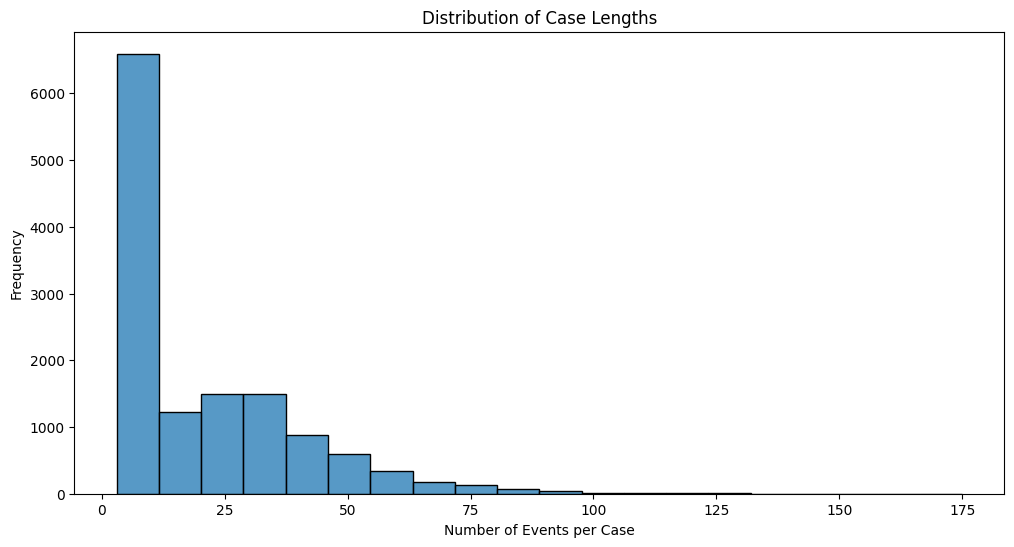

In [70]:
case_lengths = df_log.groupby('case:concept:name').size()

plt.figure(figsize=(12, 6))
sns.histplot(case_lengths, bins=20, kde=False)
plt.title('Distribution of Case Lengths')
plt.xlabel('Number of Events per Case')
plt.ylabel('Frequency')
plt.show()

### 2.4 Activities

In [73]:
# Unique Activities
unique_activities = df_log['concept:name'].unique()
print(f"Activities: {unique_activities}")

Activities: ['A_SUBMITTED' 'A_PARTLYSUBMITTED' 'A_PREACCEPTED'
 'W_Completeren aanvraag' 'A_ACCEPTED' 'O_SELECTED' 'A_FINALIZED'
 'O_CREATED' 'O_SENT' 'W_Nabellen offertes' 'O_SENT_BACK'
 'W_Valideren aanvraag' 'A_REGISTERED' 'A_APPROVED' 'O_ACCEPTED'
 'A_ACTIVATED' 'O_CANCELLED' 'W_Wijzigen contractgegevens' 'A_DECLINED'
 'A_CANCELLED' 'W_Afhandelen leads' 'O_DECLINED'
 'W_Nabellen incomplete dossiers' 'W_Beoordelen fraude']


| Activity Name                    | Description                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| **A_SUBMITTED**                  | Loan application has been submitted by the customer or agent.               |
| **A_PARTLYSUBMITTED**            | Incomplete or partial submission of a loan application.                     |
| **A_PREACCEPTED**                | Pre-acceptance check passed; initial review marked as acceptable.           |
| **W_Completeren aanvraag**      | Completing missing information or required documentation for the application.|
| **A_ACCEPTED**                   | Loan application has been formally accepted.                                 |
| **O_SELECTED**                   | Offer selected by the customer.                                              |
| **A_FINALIZED**                  | Final approval and preparation for contract execution.                       |
| **O_CREATED**                    | Offer created in the system based on application data.                       |
| **O_SENT**                       | Loan offer sent to the customer.                                            |
| **W_Nabellen offertes**         | Follow-up calls regarding sent offers.                                      |
| **O_SENT_BACK**                  | Offer returned or sent back for corrections or review.                       |
| **W_Valideren aanvraag**        | Validating application details—fraud check, credit check, etc.              |
| **A_REGISTERED**                | Application registered in back-end system.                                   |
| **A_APPROVED**                  | Loan application approved after full validation.                             |
| **O_ACCEPTED**                  | Offer accepted by the customer.                                              |
| **A_ACTIVATED**                 | Loan contract activated and funds released.                                  |
| **O_CANCELLED**                 | Offer cancelled.                                                            |
| **W_Wijzigen contractgegevens** | Adjusting or correcting contract information.                                |
| **A_DECLINED**                  | Loan application declined.                                                  |
| **A_CANCELLED**                 | Loan application cancelled by customer or agent.                             |
| **W_Afhandelen leads**          | Handling sales leads for incomplete or unsubmitted applications.            |
| **O_DECLINED**                  | Offer declined by the customer.                                              |
| **W_Nabellen incomplete dossiers** | Follow-up on incomplete applications.                                      |
| **W_Beoordelen fraude**         | Fraud evaluation or special risk assessment.                                 |

---

> **Note:**  
> Activities prefixed with:
> - `A_`: Application-level system or automated process events.
> - `W_`: Work tasks typically requiring human intervention.
> - `O_`: Offer-related system events or customer actions.

This table helps business users and analysts interpret process models and event logs clearly during discovery and analysis phases.


## 3. Data Preprocessing

### 3.1 Purpose of Preprocessing
Before applying process discovery algorithms, we need to ensure the event log is in a consistent and clean structure:

- Ensure required columns are present and properly formatted.
- Remove or handle missing values in critical fields.
- Standardize column names according to `pm4py` expectations.
- Remove duplicates or irrelevant columns.


### 3.2 Cleaning and Standardizing Column Names

We focus on the following standard columns:

- `case:concept:name`: Unique case ID
- `concept:name`: Activity
- `time:timestamp`: Timestamp
- `org:resource`: (Optional) Resource performing the activity
- Any additional case attributes like `case:AMOUNT_REQ`

In [75]:
# Rename columns to pm4py standard names (in our case already based on best practices)
df_clean = df_log.rename(columns={
    'case:concept:name': 'case:concept:name',
    'concept:name': 'concept:name',
    'time:timestamp': 'time:timestamp',
    'org:resource': 'org:resource',
    'case:AMOUNT_REQ': 'case:AMOUNT_REQ'
})

In [23]:
# Convert timestamp column to datetime type
df_clean['time:timestamp'] = pd.to_datetime(df_clean['time:timestamp'])

### 3.3 Handling Missing Values and Duplicates
Critical columns for process mining are:
- case:concept:name
- concept:name
- time:timestamp

In [76]:
# Drop rows with missing essential values
df_clean.dropna(subset=['case:concept:name', 'concept:name', 'time:timestamp'], inplace=True)

# Check again for missing values
print(df_clean.isnull().sum())

# Remove duplicates
df_clean.drop_duplicates(inplace=True)

# Confirm shape after cleaning
print(df_clean.shape)

org:resource            18010
lifecycle:transition        0
concept:name                0
time:timestamp              0
case:REG_DATE               0
case:concept:name           0
case:AMOUNT_REQ             0
dtype: int64
(262200, 7)


### 3.4 Validate Consistency Across Cases
Important to make sure each case:concept:name has multiple events (important for process discovery):

In [78]:
case_counts = df_clean['case:concept:name'].value_counts()

# Show statistics about case lengths
print(case_counts.describe())

count    13087.000000
mean        20.035149
std         19.944321
min          3.000000
25%          3.000000
50%         11.000000
75%         31.000000
max        175.000000
Name: count, dtype: float64


In [79]:
# Remove singleton cases (optional but can improve model quality)
valid_cases = case_counts[case_counts > 1].index
df_clean = df_clean[df_clean['case:concept:name'].isin(valid_cases)]

print(f"Remaining cases: {df_clean['case:concept:name'].nunique()}")

Remaining cases: 13087


### 3.5 Saving the Cleaned Event Log for Later Steps
Saved cleaned log to avoid reprocessing:

In [26]:
df_clean.to_csv('financial_log_cleaned.csv', index=False)

print("Cleaned event log saved as 'financial_log_cleaned.csv'")

Cleaned event log saved as 'financial_log_cleaned.csv'


## 4. Create PM4Py Event Log and Analyze Case Durations

To analyze and visualize the actual process, we need to:
- Convert our cleaned DataFrame into a PM4Py `EventLog` object
- Validate that it’s structured correctly
- Analyze case durations to understand how long each case took to complete

We will use both **PM4Py** and **manual pandas-based logic** for more robust and transparent performance analysis.

### 4.1 Convert Cleaned DataFrame to PM4Py Event Log

PM4Py requires specific columns:
- `case:concept:name`: Unique case ID
- `concept:name`: Activity name
- `time:timestamp`: Event timestamp  
Optional: `org:resource`, `lifecycle:transition`, and other case attributes


In [83]:
# Convert the cleaned DataFrame into an EventLog object
event_log = log_converter.apply(df_clean, variant=log_converter.Variants.TO_EVENT_LOG)

# Quick confirmation
print(f"Number of cases in event log: {len(event_log)}")

# Preview a few traces
for trace in event_log[:2]:
    print(f"Trace for case {trace.attributes['concept:name']}:")
    for event in trace:
        print(f"  {event['concept:name']} at {event['time:timestamp']}")
    print("---")

Number of cases in event log: 13087
Trace for case 173688:
  A_SUBMITTED at 2011-10-01 00:38:44.546000+00:00
  A_PARTLYSUBMITTED at 2011-10-01 00:38:44.880000+00:00
  A_PREACCEPTED at 2011-10-01 00:39:37.906000+00:00
  W_Completeren aanvraag at 2011-10-01 00:39:38.875000+00:00
  W_Completeren aanvraag at 2011-10-01 11:36:46.437000+00:00
  A_ACCEPTED at 2011-10-01 11:42:43.308000+00:00
  O_SELECTED at 2011-10-01 11:45:09.243000+00:00
  A_FINALIZED at 2011-10-01 11:45:09.243000+00:00
  O_CREATED at 2011-10-01 11:45:11.197000+00:00
  O_SENT at 2011-10-01 11:45:11.380000+00:00
  W_Nabellen offertes at 2011-10-01 11:45:11.554000+00:00
  W_Completeren aanvraag at 2011-10-01 11:45:13.917000+00:00
  W_Nabellen offertes at 2011-10-01 12:15:41.290000+00:00
  W_Nabellen offertes at 2011-10-01 12:17:08.924000+00:00
  W_Nabellen offertes at 2011-10-08 16:26:57.720000+00:00
  W_Nabellen offertes at 2011-10-08 16:32:00.886000+00:00
  W_Nabellen offertes at 2011-10-10 11:32:22.495000+00:00
  O_SENT_BA

### 4.2 Case Duration Analysis — Manual & Reliable
Although PM4Py offers automatic duration calculation, real-life logs often contain mixed lifecycle:transition values (e.g., START, SCHEDULE, COMPLETE) that require manual handling.

To avoid issues and ensure accuracy, we calculate durations directly with pandas.

####4.3. Calculate Duration Per Case

In [36]:
# Group events by case and get min/max timestamps
duration_per_case = (
    df_clean.groupby("case:concept:name")["time:timestamp"]
    .agg(["min", "max"])
)

# Calculate duration (end - start)
duration_per_case["duration"] = duration_per_case["max"] - duration_per_case["min"]

# Preview
duration_per_case.head()


min  \
case:concept:name                                    
173688            2011-10-01 00:38:44.546000+00:00   
173691            2011-10-01 08:08:58.256000+00:00   
173694            2011-10-01 08:10:30.287000+00:00   
173697            2011-10-01 08:11:08.866000+00:00   
173700            2011-10-01 08:15:39.894000+00:00   

                                               max                 duration  
case:concept:name                                                            
173688            2011-10-13 10:37:37.026000+00:00  12 days 09:58:52.480000  
173691            2011-10-10 14:17:34.633000+00:00   9 days 06:08:36.377000  
173694            2012-02-15 12:29:26.299000+00:00 137 days 04:18:56.012000  
173697            2011-10-01 08:11:46.420000+00:00   0 days 00:00:37.554000  
173700            2011-10-01 08:16:21.037000+00:00   0 days 00:00:41.143000

In [84]:
# Filter out single-event cases or zero-duration records
valid_durations = duration_per_case[duration_per_case["duration"] > pd.Timedelta(0)]

print(f"Number of cases with valid duration: {len(valid_durations)}")

# Summary statistics of case durations
print(valid_durations["duration"].describe())


Number of cases with valid duration: 13087
count                         13087
mean      8 days 14:55:16.341099488
std      12 days 03:02:31.229761150
min          0 days 00:00:01.855000
25%          0 days 00:00:54.466000
50%          0 days 19:24:17.434000
75%         14 days 04:36:29.786500
max        137 days 04:18:56.012000
Name: duration, dtype: object


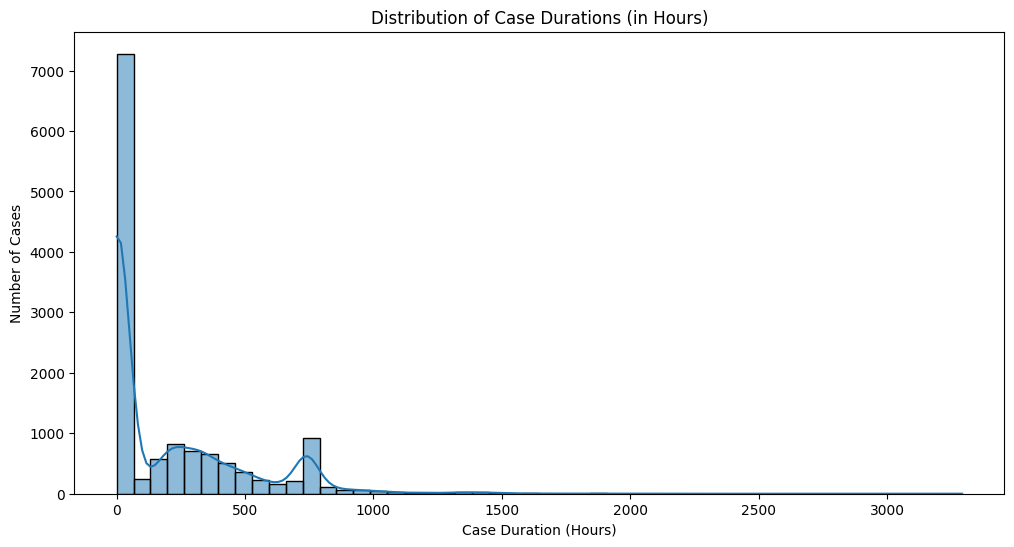

In [85]:
# Convert timedelta to hours for better readability
valid_durations["duration_hours"] = valid_durations["duration"].dt.total_seconds() / 3600

plt.figure(figsize=(12, 6))
sns.histplot(valid_durations["duration_hours"], bins=50, kde=True)
plt.title("Distribution of Case Durations (in Hours)")
plt.xlabel("Case Duration (Hours)")
plt.ylabel("Number of Cases")
plt.show()

## 5. Process Discovery 

### 5.1 Purpose of Process Discovery

**Process Discovery** allows us to automatically reconstruct actual business process models from event log data. In this step, we will:

- Generate a structured **Process Tree** using **Inductive Miner**.
- Convert that Process Tree into a **Petri Net** for further analysis or conformance checking.
- Visualize both models.
- Apply **Heuristic Miner** as an alternative discovery technique focusing on frequency and dependency strength.

### 5.2 Process Discovery Using Inductive Miner

#### Why Inductive Miner?

- It guarantees a sound and structured model.
- Supports structured conversion to Petri Nets for compliance and conformance checking.

#### 5.2.1 Apply Inductive Miner → Generate Process Tree

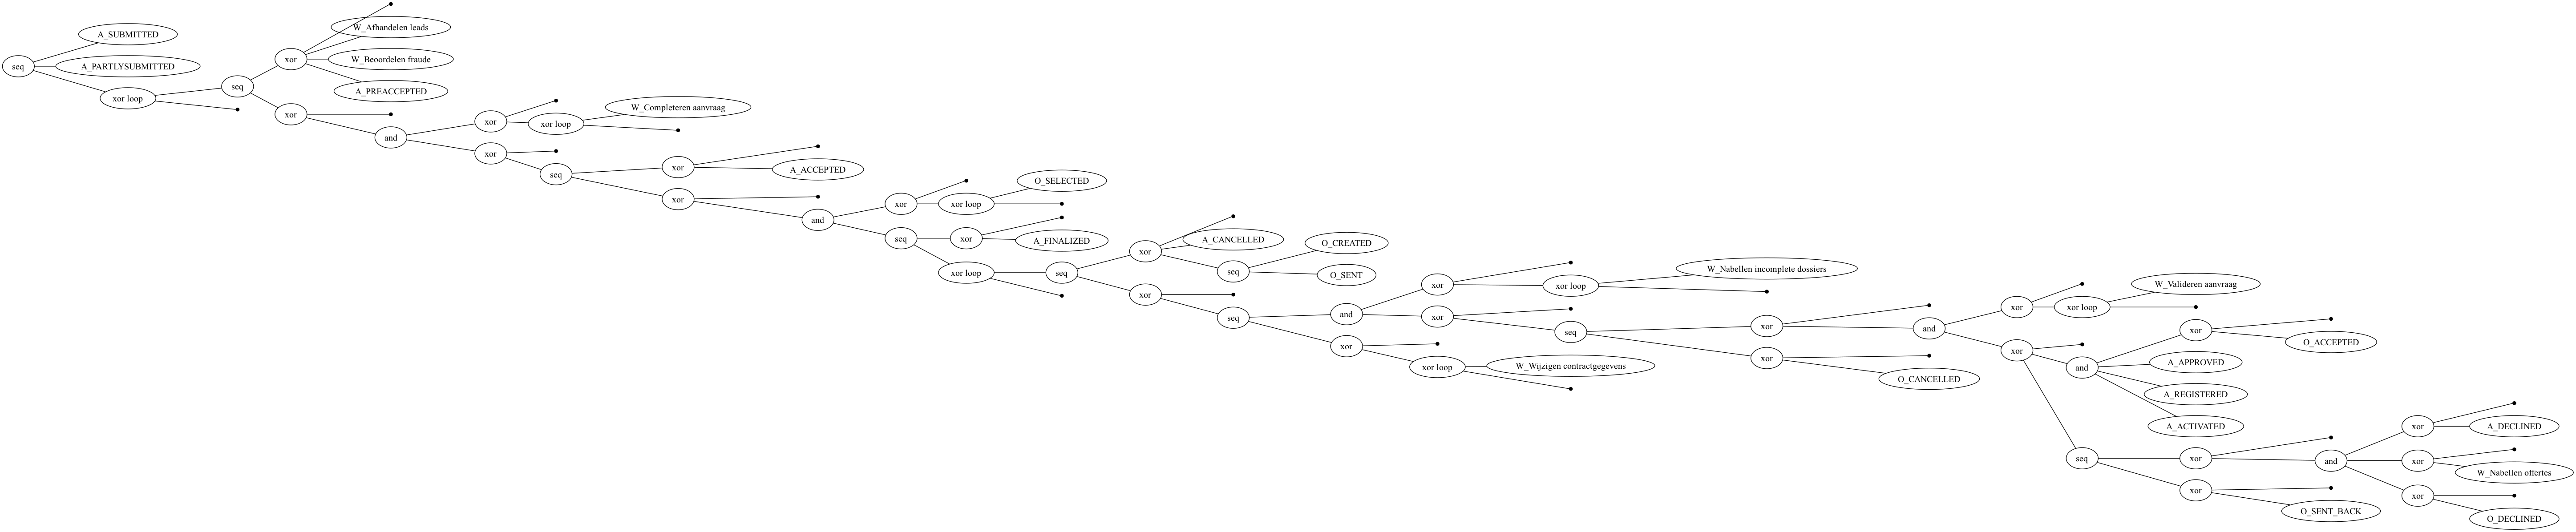

In [47]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer

# Apply Inductive Miner with IM variant to get Process Tree
process_tree = inductive_miner.apply(event_log, variant=inductive_miner.Variants.IM)

# Visualize Process Tree
gviz = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz)

The process tree visualized through Inductive Miner highlights the following key structures and insights:

- **Clear Starting Point:**  
  Every loan application starts with `A_SUBMITTED` → `A_PARTLYSUBMITTED`, establishing a standardized entry step.

- **Main Decision Points & Parallel Activities:**  
  After `A_PREACCEPTED`, the process diverges into tasks like `W_Completeren aanvraag` (completing information), `W_Beoordelen fraude` (fraud check), and `W_Afhandelen leads` (handling leads).  
  Further along, activities such as `A_ACCEPTED`, `O_SELECTED`, and `A_FINALIZED` may occur simultaneously, reflecting parallel handling of offers, contracts, and approvals.

- **Loops & Rework:**  
  The process shows `xor loop` and `seq loop` markers, indicating repetitive tasks like `W_Wijzigen contractgegevens` (contract adjustments) or `W_Nabellen incomplete dossiers` (follow-ups on incomplete applications).

- **Multiple End States:**  
  The process concludes with outcomes like `A_ACTIVATED` (loan activated), `A_DECLINED`, `A_CANCELLED`, or `O_CANCELLED`.  
  This diversity reflects real-world variability in customer journeys and business decisions.

> **Summary:**  
> The process tree reveals a structured loan application workflow with defined entry points, decision splits, parallel execution, necessary rework, and flexible end states—aligning with typical financial service processes.


#### 5.2.2 Convert Process Tree → Petri Net

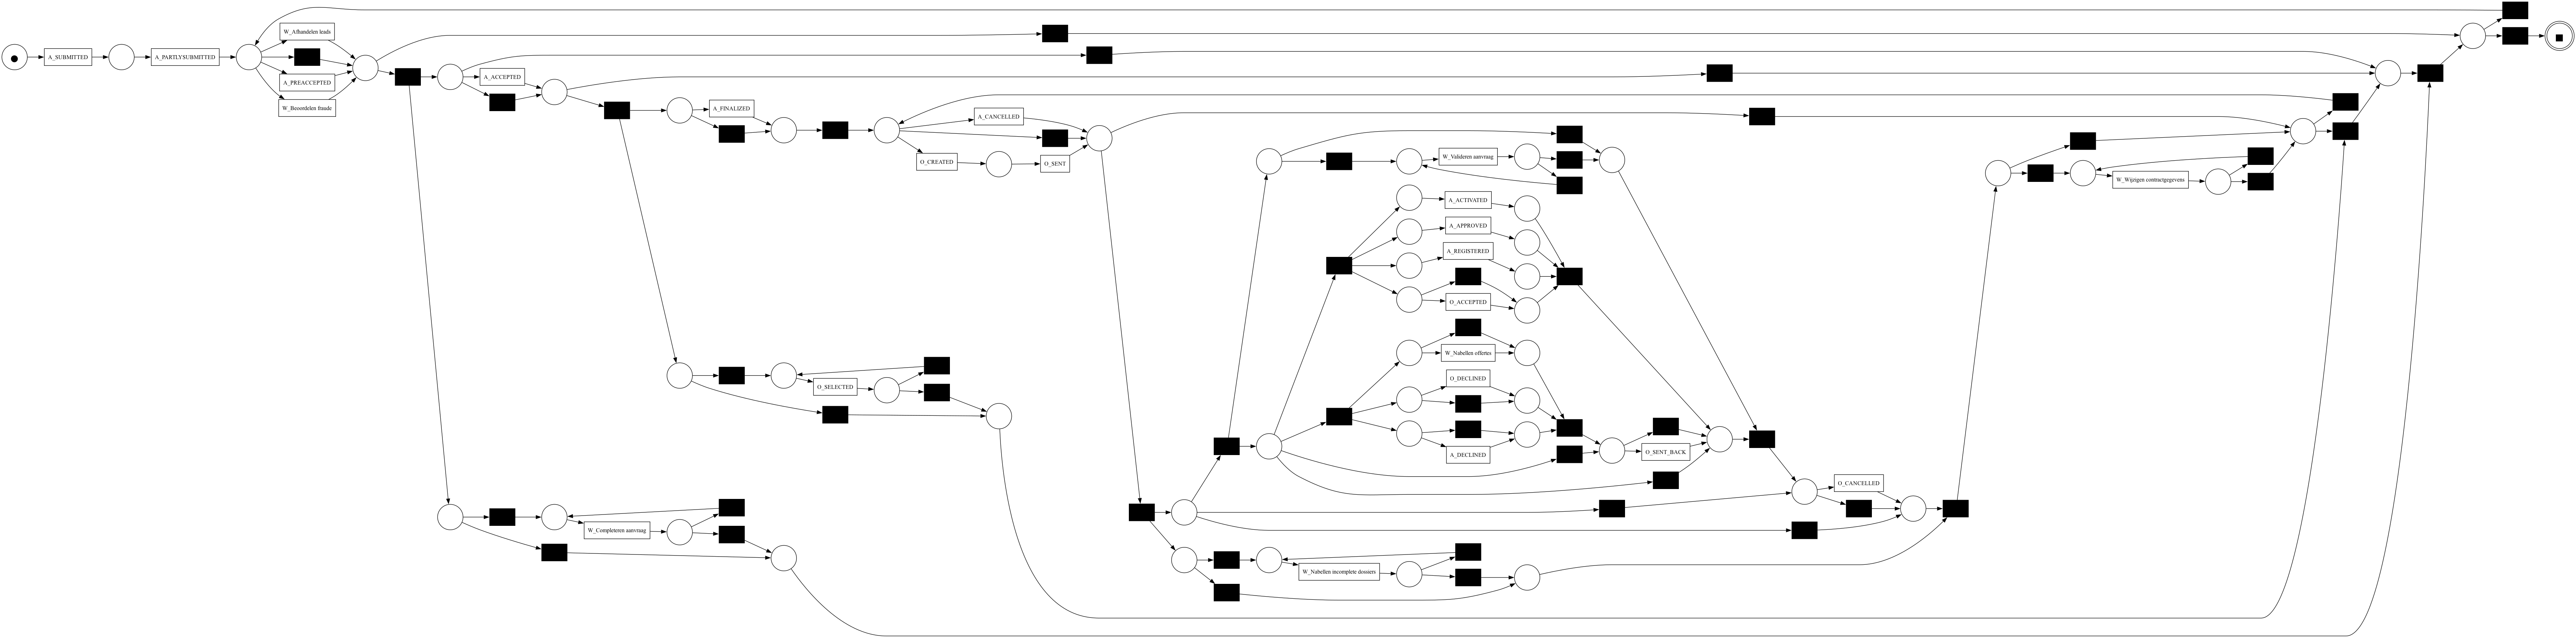

In [48]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Convert Process Tree to Petri Net
net, initial_marking, final_marking = pt_converter.apply(process_tree)

# Visualize Petri Net
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)


The Petri Net derived from the process tree using Inductive Miner represents the same process in a more detailed, token-based structure suitable for conformance checking.

- **Clear Entry Point:**  
  - The process always starts at `A_SUBMITTED` followed by `A_PARTLYSUBMITTED`.
  - A single input place marks the start, confirming a standardized beginning for all cases.

- **Decision Points & Parallel Execution:**  
  - After `A_PREACCEPTED`, parallel tasks such as `W_Beoordelen fraude`, `W_Afhandelen leads`, and `W_Completeren aanvraag` can occur concurrently.
  - The Petri Net structure uses multiple transitions and places to reflect this parallelism clearly.

- **Loops & Rework Paths:**  
  - Loops appear as backward arcs and repeated places, particularly around:
    - `W_Wijzigen contractgegevens` (Contract adjustments).
    - `W_Nabellen incomplete dossiers` (Follow-ups on incomplete dossiers).
  - This confirms the business reality of process iterations.

- **Multiple End States:**  
  - The process can end at several transitions, including:
    - `A_ACTIVATED`, `A_DECLINED`, `A_CANCELLED`, `O_CANCELLED`.
  - These multiple output places represent the varied outcomes in real loan processes.

- **Token Flow & Conformance Relevance:**  
  - Petri Net layout is optimized for token replay analysis.
  - Black squares represent invisible transitions, which help model routing decisions and silent steps not shown in the event log.

---

> **Summary:**  
> The Petri Net complements the process tree by offering a formal model structure ideal for conformance checking and detailed process analysis. It retains key business logic including parallelism, loops, and multiple end states while providing a foundation for performance metrics and compliance validation.


### 5.3 Process Discovery Using Heuristic Miner
Why Heuristic Miner?
Captures frequent behavior and handles noise.
Easier to apply directly to large, real-life event logs.

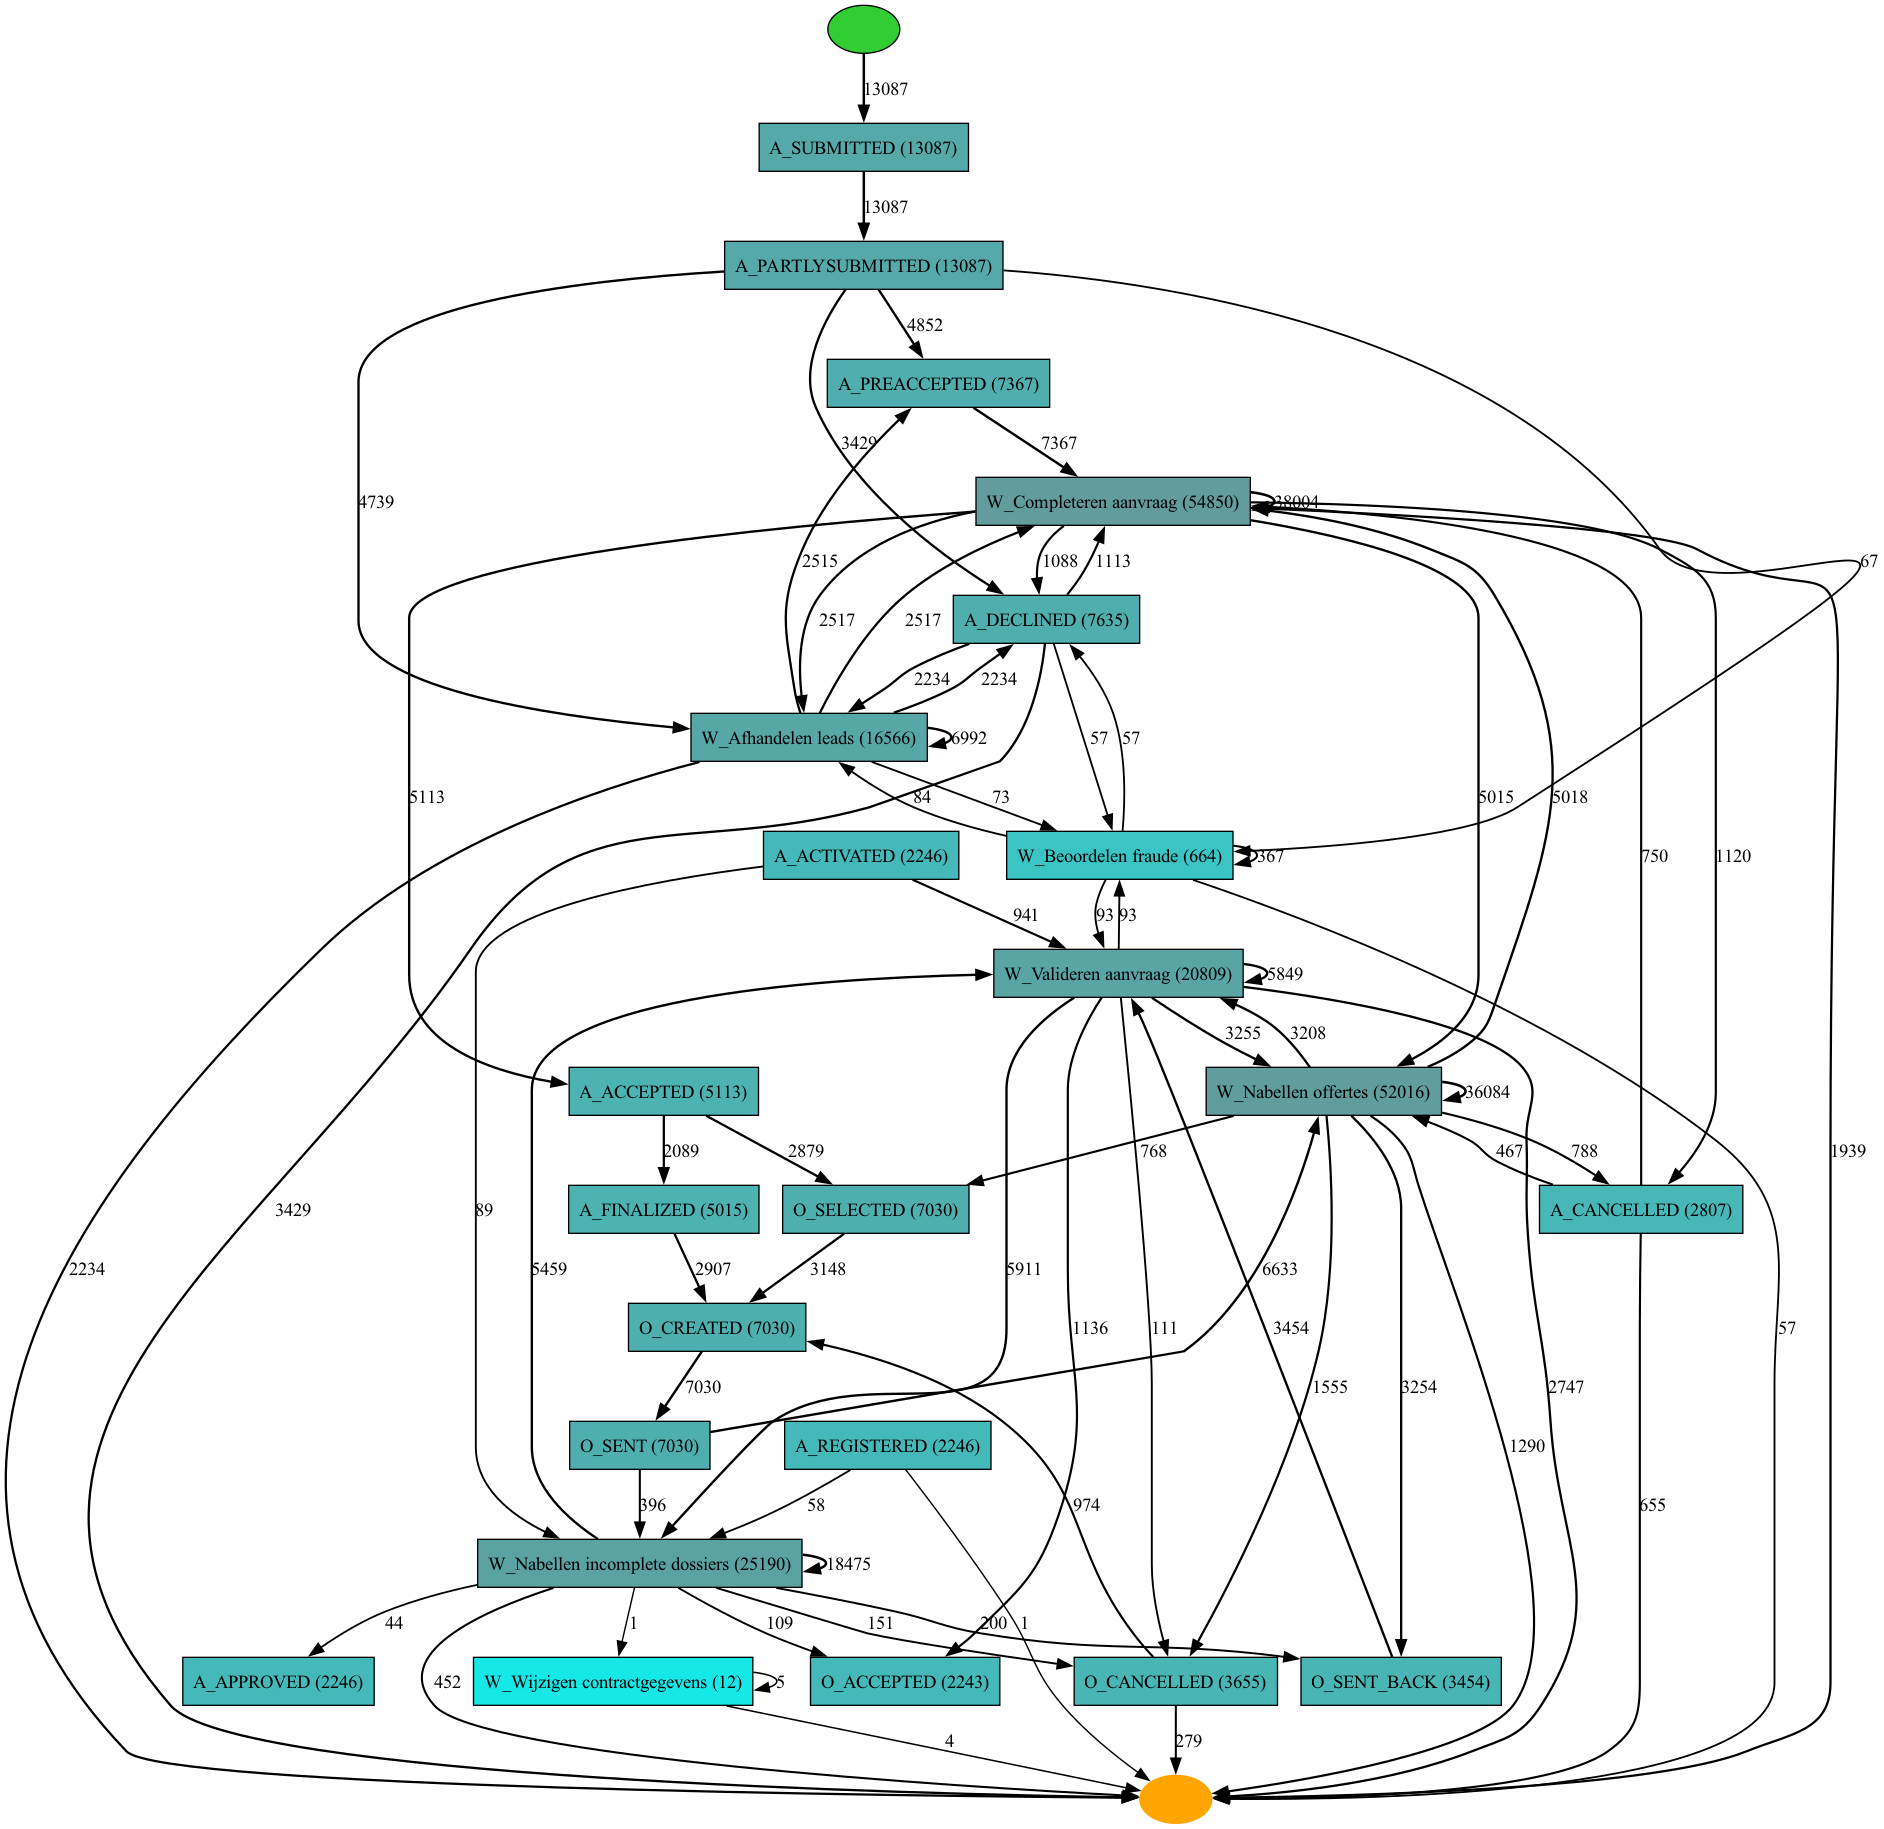

In [49]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Apply Heuristic Miner
heu_net = heuristics_miner.apply_heu(event_log)

# Visualize Heuristic Net
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)


The Heuristic Miner model focuses on the most frequent behavior paths within the loan application process. It provides a dependency- and frequency-driven process map, optimized for exploring real-world, less structured process execution.


- **Clear Starting Point:**  
  - All cases start from `A_SUBMITTED` → `A_PARTLYSUBMITTED`.  
  - This is the dominant entry path with the highest case frequency count visible in the model.

- **Main Flow Dominance:**  
  - The thickest paths show the most common route:
    - `A_PREACCEPTED` → `W_Completeren aanvraag` → `A_ACCEPTED`.  
  - These steps form the loan process’s “happy path.”

- **High-Frequency Parallel Steps:**  
  - Frequent parallel work includes:
    - `W_Afhandelen leads`, `W_Valideren aanvraag`, `W_Beoordelen fraude`.  
  - Their positioning and weight in the model suggest they are regularly involved in standard case handling.

- **Loops and Repeated Actions:**  
  - Repeated flow patterns appear around:
    - `W_Nabellen offertes`, `W_Nabellen incomplete dossiers`, and `W_Wijzigen contractgegevens`.  
  - These loops signal areas where customer or internal follow-ups frequently occur.

- **Multiple Outcomes with Measurable Frequencies:**  
  - The model visually highlights:
    - `A_ACTIVATED` → most frequent successful outcome.
    - `A_DECLINED`, `A_CANCELLED`, `O_CANCELLED` → common alternative endpoints.  
  - Frequency counts attached to each outcome make business prioritization clearer.

- **Noise Handling:**  
  - Heuristic Miner naturally downplays less frequent paths, which keeps the model focused and readable compared to Petri Nets or Inductive Miner trees.

---

> **Summary:**  
> The Heuristic Miner graph emphasizes real-world process behavior based on activity frequency and dependency strength. It clearly identifies dominant flows, parallel subprocesses, and rework loops while visually filtering out rare process variants for a more business-friendly overview.


- Inductive Miner: Clear structure, compliance-ready -->	May oversimplify complex variants
- Heuristic Miner: Captures common paths, handles noise -->	Can appear cluttered and less structured

### 5.4 Directly-Follows Graph (DFG)



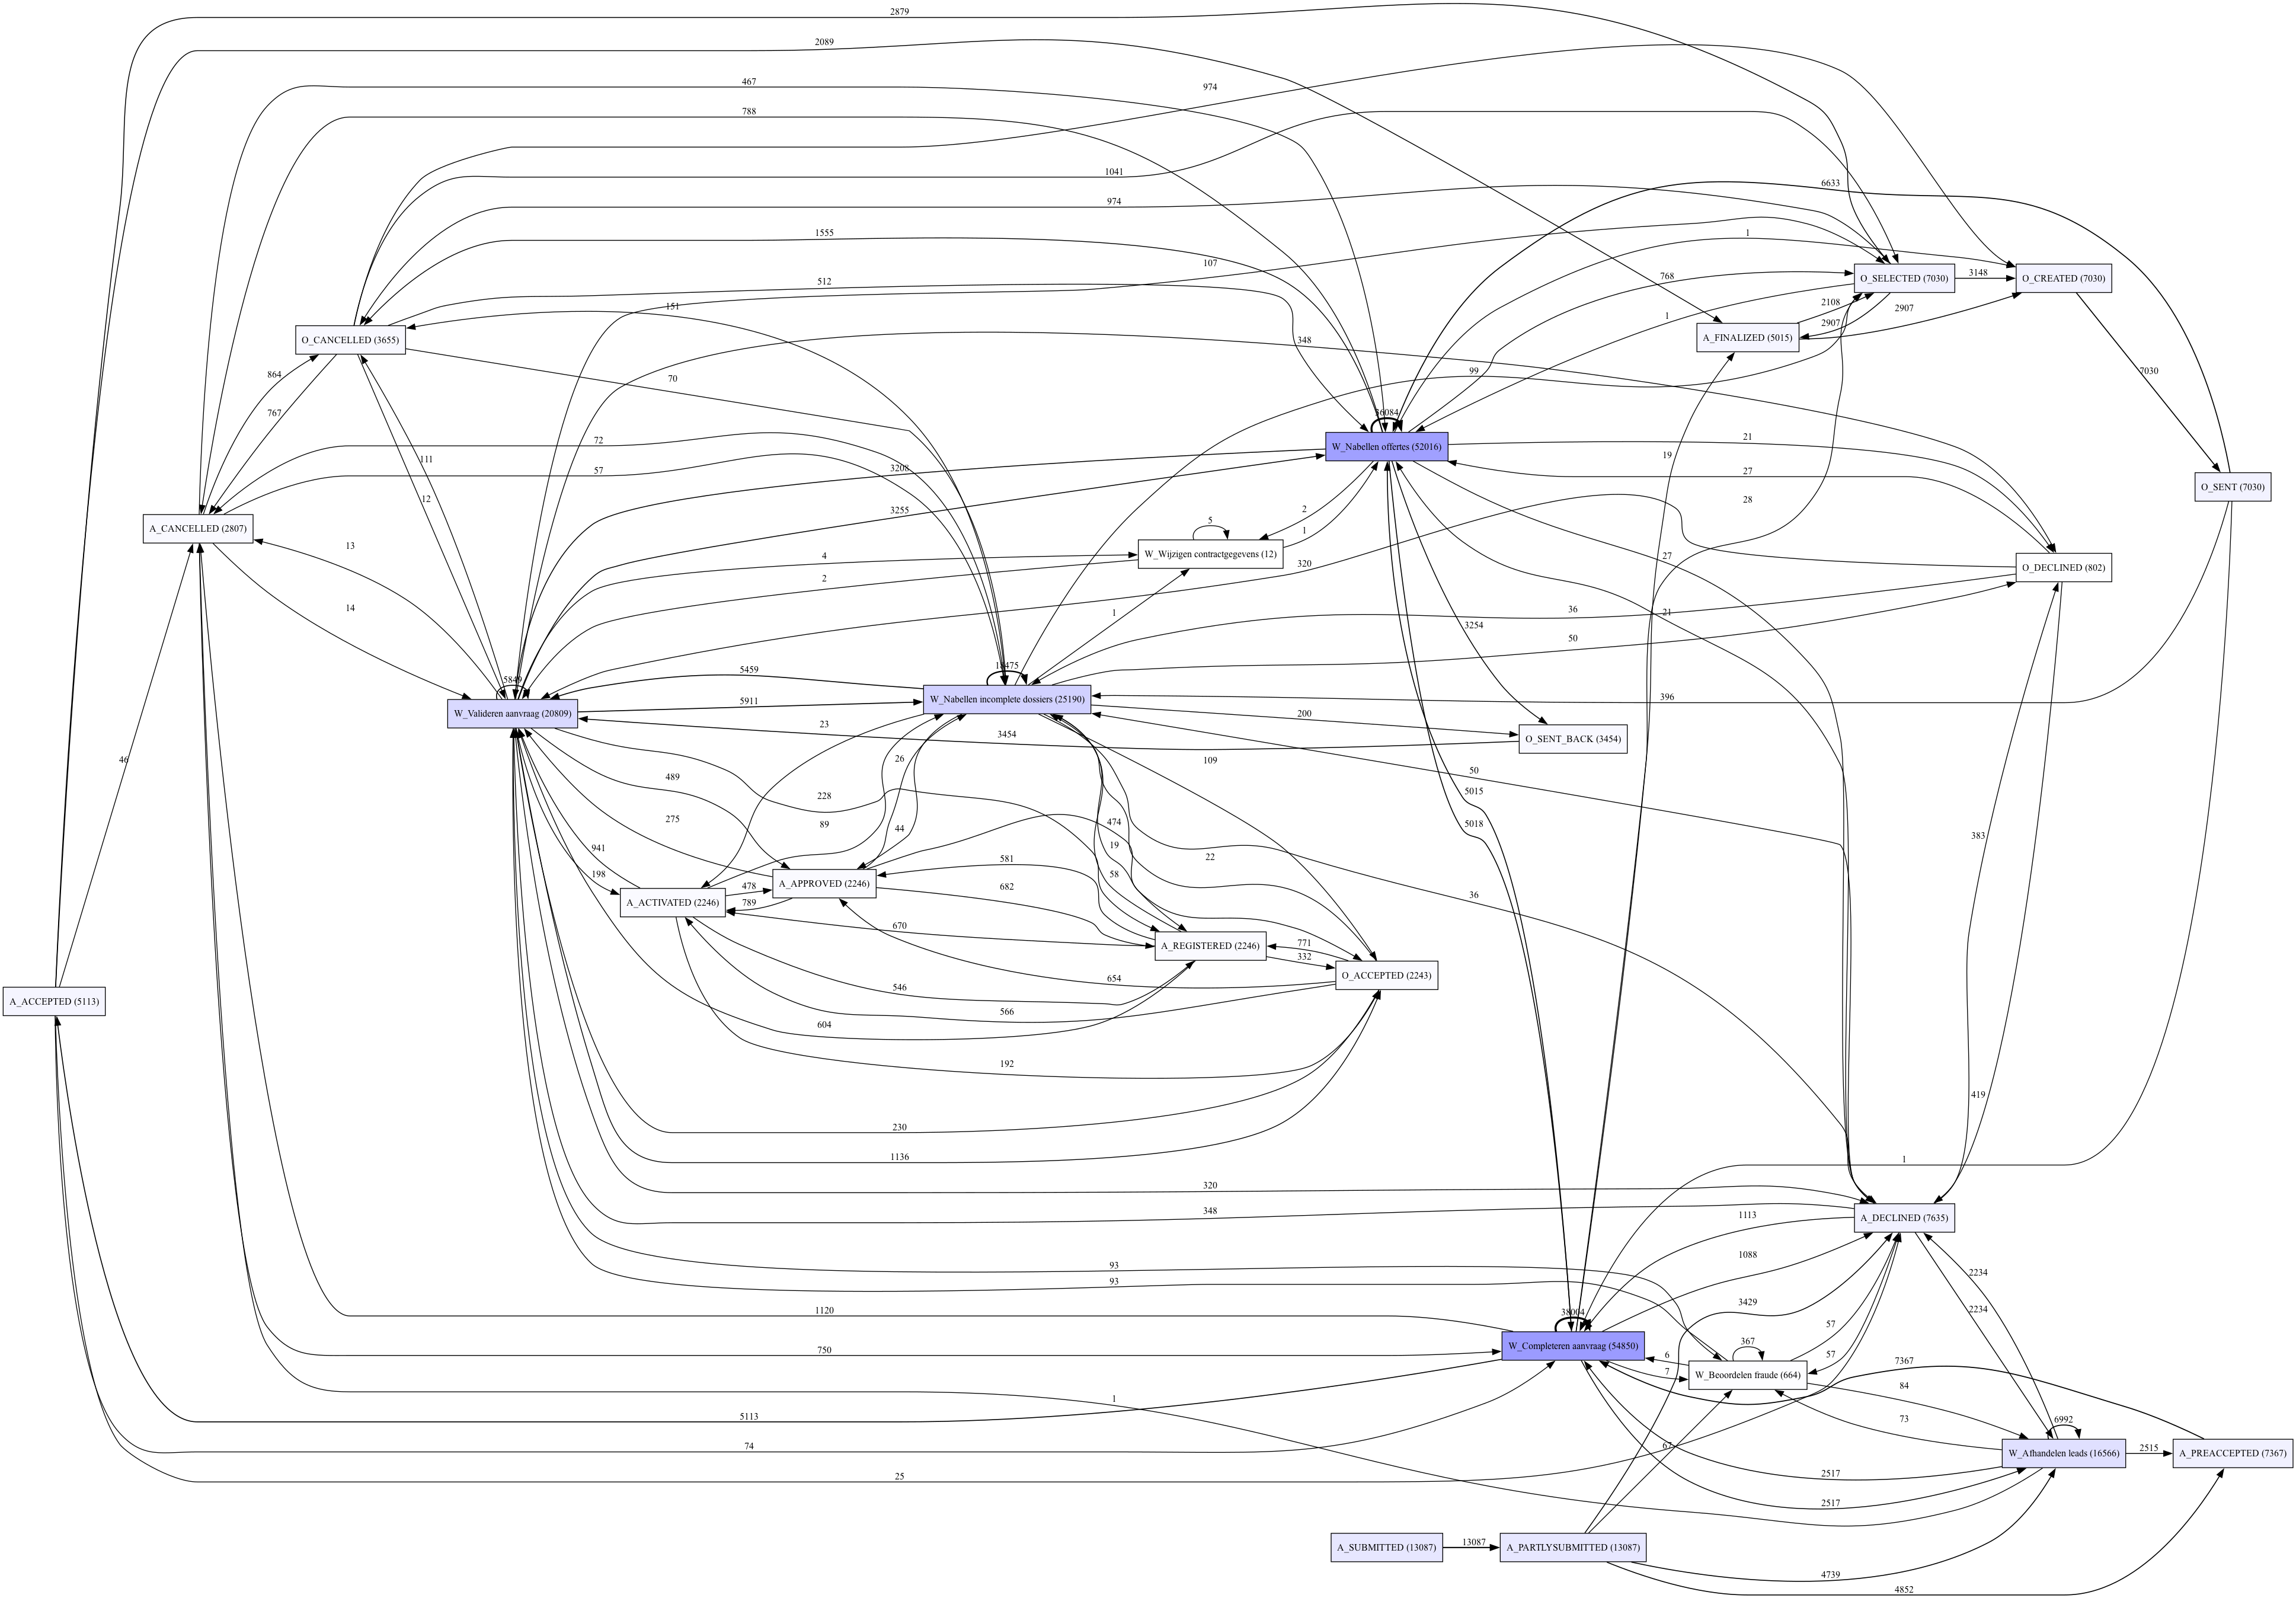

In [61]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# Discover DFG based on frequency
dfg_freq = dfg_discovery.apply(event_log)

# Visualize Frequency DFG
gviz = dfg_visualizer.apply(dfg_freq, log=event_log, variant=dfg_visualizer.Variants.FREQUENCY)
dfg_visualizer.view(gviz)


The Directly-Follows Graph (DFG) visualizes all observed direct transitions between activities in the event log, focusing on both frequency and structure.

- **Clear Starting Activities:**  
  - The process consistently starts with `A_SUBMITTED` → `A_PARTLYSUBMITTED`.  
  - The DFG confirms this sequence is present in every case.

- **Dominant Paths and Frequencies:**  
  - The thickest arrows highlight the most common transitions:
    - `A_PARTLYSUBMITTED` → `A_PREACCEPTED` → `W_Completeren aanvraag`.  
    - `W_Completeren aanvraag` → `A_DECLINED` or further processing steps.  
  - Frequency labels show transition counts, helping identify which flows dominate.

- **High-Complexity Areas:**  
  - Central nodes like `W_Valideren aanvraag`, `W_Nabellen offertes`, and `W_Nabellen incomplete dossiers` have many incoming and outgoing arrows.  
  - These nodes are process hubs and likely bottlenecks due to their connection volume.

- **Loops and Rework Indicators:**  
  - DFG shows clear looping paths, especially:
    - Around `W_Nabellen offertes` and `W_Nabellen incomplete dossiers`.  
  - These loops reflect repeated customer contact or internal follow-up tasks.

- **Multiple End States:**  
  - Observable terminal activities include:
    - `A_ACTIVATED`, `A_DECLINED`, `A_CANCELLED`, `O_CANCELLED`.  
  - These end states align with expected loan process outcomes.

- **Simplified Compared to Petri Net:**  
  - The DFG shows process frequency paths but omits routing constructs (no AND/XOR gates).  
  - It’s easier to read for frequency insights but less precise for compliance/conformance checking.

---

> **Summary:**  
> The DFG provides a fast and clear overview of the most frequent process paths, bottlenecks, and rework cycles in the loan application process. It is ideal for quick exploratory analysis and dashboard integration, focusing on volume-driven insights rather than structural compliance.


### 5.5 Alpha Miner 

### Why Alpha Miner Is Less Common in Practice

- **Strengths:** Simple, easy to understand.  
- **Weaknesses:** Cannot handle loops, noise, or complex real-world behavior.  
- Best used for learning or very controlled, clean event logs.

---

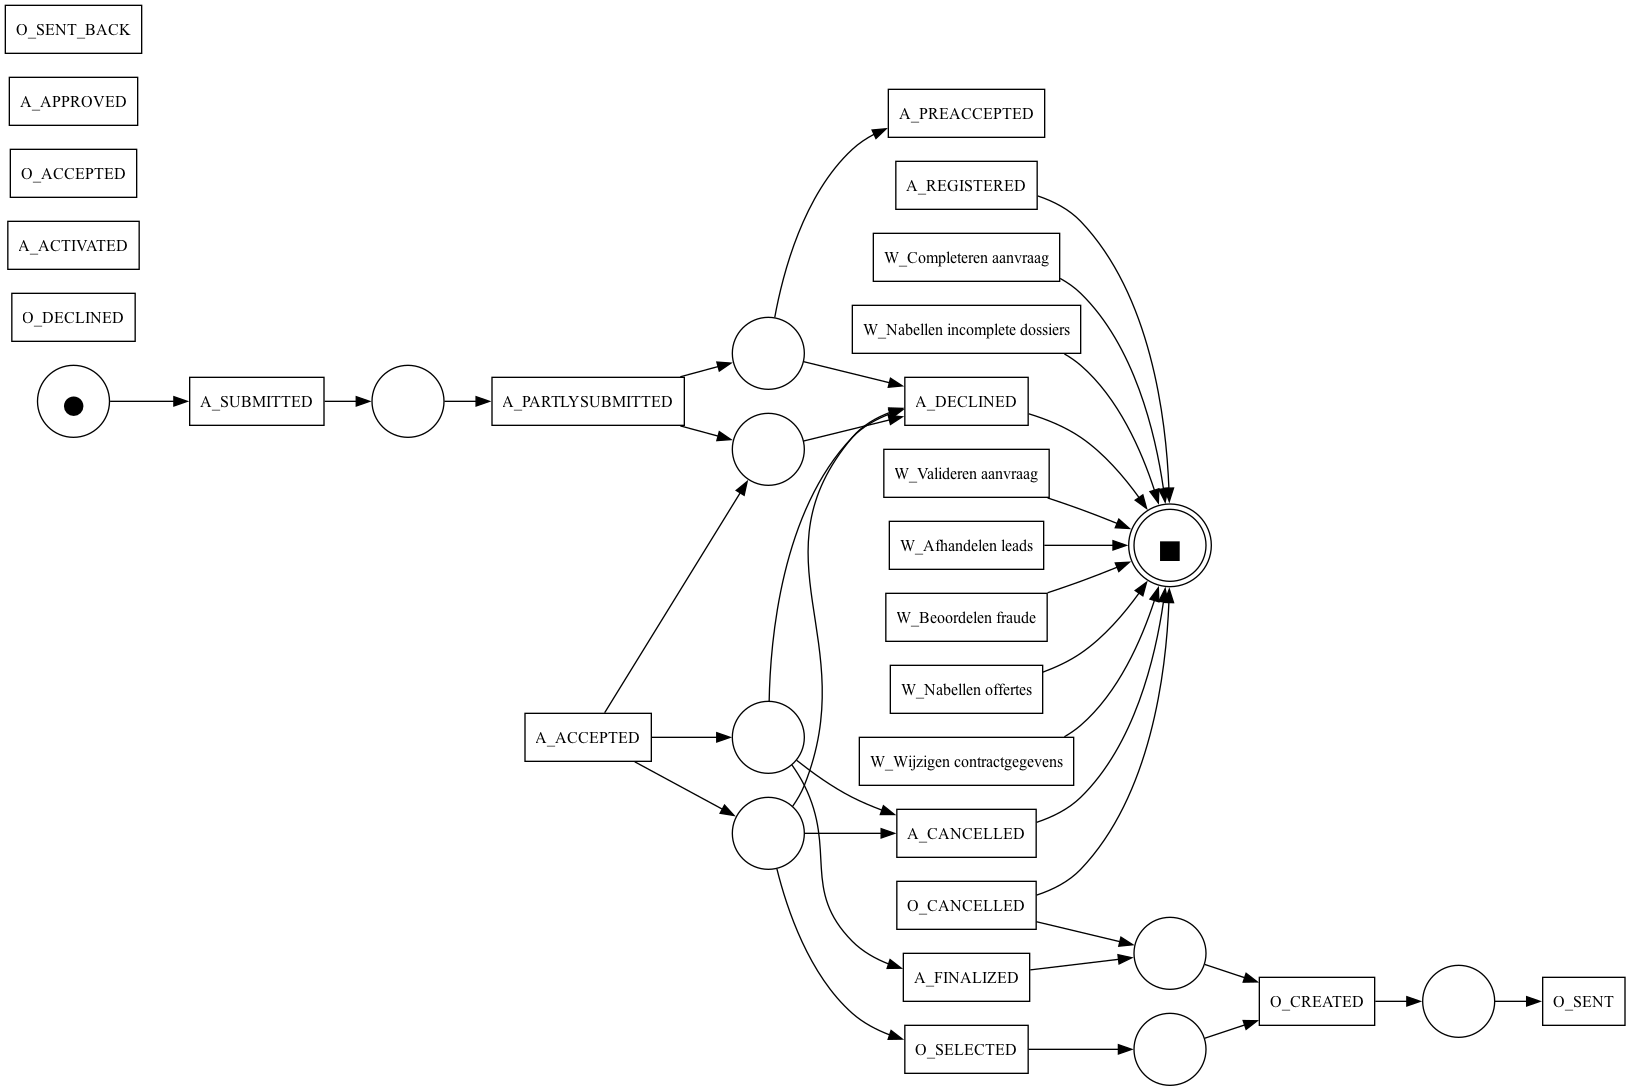

In [62]:
### Apply Alpha Miner Using PM4Py

from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Apply Alpha Miner to event log
net_alpha, initial_marking_alpha, final_marking_alpha = alpha_miner.apply(event_log)

# Visualize Alpha Miner Petri Net
gviz_alpha = pn_visualizer.apply(net_alpha, initial_marking_alpha, final_marking_alpha)
pn_visualizer.view(gviz_alpha)

The Alpha Miner algorithm produces a Petri Net focusing on directly-follows relations without considering frequency or noise tolerance. It reflects a more theoretical structure useful for educational purposes.

---

- **Simplified Start:**  
  - As expected, the process starts with `A_SUBMITTED` → `A_PARTLYSUBMITTED`.
  - This is consistent across all process discovery methods.

- **Split into Multiple Parallel Branches:**  
  - Alpha Miner creates a broad split after `A_PARTLYSUBMITTED` leading directly to activities like:
    - `A_PREACCEPTED`, `A_REGISTERED`, `W_Completeren aanvraag`, `A_DECLINED`, `W_Valideren aanvraag`.
  - This structure does not show frequency prioritization, making it less business-representative.

- **Reduced Structural Detail Compared to Inductive Miner:**  
  - Unlike Inductive or Heuristic Miner, Alpha Miner does not emphasize loops or frequency-driven prioritization.
  - Parallel tasks are modeled as parallel split-joins without indication of actual behavioral patterns.

- **End State Simplification:**  
  - Final activities such as `A_CANCELLED`, `O_CANCELLED`, `A_ACTIVATED`, `A_APPROVED` are represented as simple ends without intermediary routing constructs.
  - This means loss of intermediate control-flow logic present in real processes.

---

> **Summary:**  
> Alpha Miner provides a basic, theoretical Petri Net suitable for learning process discovery fundamentals. However, it lacks the granularity, noise handling, and real-world relevance seen in models created by Inductive Miner or Heuristic Miner. It is best used for academic illustration rather than business decision support.

### 5.6 Comparison between different Methods

| Algorithm           | When to Use                                          | Strengths                         | Limitations                           |
| ------------------- | ---------------------------------------------------- | --------------------------------- | ------------------------------------- |
| **Alpha Miner**     | Educational demos, simple event logs, Training, Academic Exercises            | Easy to understand                | Fails with noise, loops, complex logs |
| **Inductive Miner** | Standard business processes, SAP Signavio-style logs, Business Process Optimization | Structured, always sound          | Can simplify rare behaviors           |
| **Heuristic Miner** | Real-world logs with exceptions and loops            | Handles noise, shows common paths | Less structured output                |
| **DFG Discovery**   | Exploratory analysis, dashboards                     | Fast, easy to visualize           | No formal model structure             |


#### Combining different Models

| Use Case                        | Recommended Technique                  |
| ------------------------------- | -------------------------------------- |
| Exploring messy real-world data | Heuristic Miner + DFG Frequency        |
| SAP Signavio-aligned modeling   | Inductive Miner + Conformance Checking |
| Performance dashboard building  | DFG Frequency + Performance Overlay    |


## 6. Performance Analysis

### 6.1 Purpose of Performance Analysis

Once we have a discovered process model, we can analyze how long different steps in the process take.  
Performance analysis in process mining focuses on:

- **Cycle Time**: Total time from the first to the last event in a case.
- **Activity Duration**: Time taken for individual activities.
- **Waiting Time**: Time gaps between events in the same case.
- **Bottleneck Identification**: Activities or transitions where delays typically occur.



### 6.2 Cycle Time Analysis (Manual Using Pandas)

We already calculated case durations in **Step 4**.  
Now we summarize and visualize them again for performance insights.

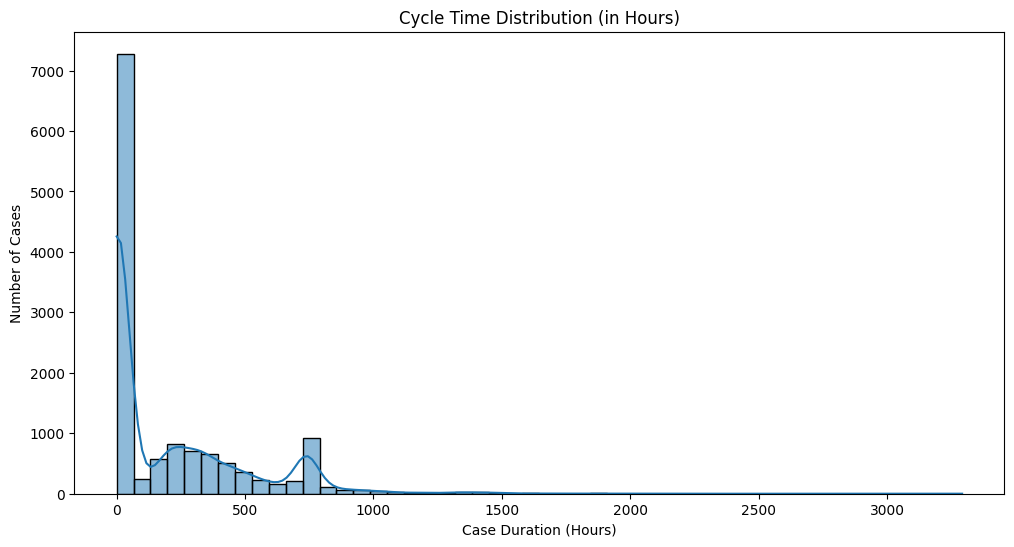

count    13087.000000
mean       206.921206
std        291.042008
min          0.000515
25%          0.015129
50%         19.404843
75%        340.608274
90%        730.849341
95%        752.208467
max       3292.315559
Name: duration_hours, dtype: float64


In [50]:
# Use valid_durations from Step 5
plt.figure(figsize=(12, 6))
sns.histplot(valid_durations["duration_hours"], bins=50, kde=True)
plt.title("Cycle Time Distribution (in Hours)")
plt.xlabel("Case Duration (Hours)")
plt.ylabel("Number of Cases")
plt.show()

# Display percentile statistics
print(valid_durations["duration_hours"].describe(percentiles=[.25, .5, .75, .9, .95]))

### 6.3 Sojourn Time and Activity Waiting Time (PM4Py)
We now analyze performance on the discovered Petri Net using PM4Py’s built-in tools.

Calculate Performance Metrics on Petri Net

#### 6.3.1 Sojourn Time

In [94]:
# Convert event log to DataFrame if needed
df = pm4py.convert_to_dataframe(event_log)

# Filter for relevant columns
df = df[['case:concept:name', 'concept:name', 'time:timestamp', 'lifecycle:transition']]

# Pivot table: one row per case + activity, columns for START and COMPLETE timestamps
pivot_df = df.pivot_table(index=['case:concept:name', 'concept:name'],
                          columns='lifecycle:transition',
                          values='time:timestamp',
                          aggfunc='first').reset_index()

# Calculate sojourn time
pivot_df['sojourn_time'] = pivot_df['COMPLETE'] - pivot_df['START']

# View results
pivot_df[['case:concept:name', 'concept:name', 'sojourn_time']].dropna()


lifecycle:transition case:concept:name            concept:name  \
13                              173688  W_Completeren aanvraag   
14                              173688     W_Nabellen offertes   
15                              173688    W_Valideren aanvraag   
30                              173691  W_Completeren aanvraag   
31                              173691     W_Nabellen offertes   
...                                ...                     ...   
106990                          214370      W_Afhandelen leads   
106999                          214373      W_Afhandelen leads   
107000                          214373  W_Completeren aanvraag   
107001                          214373     W_Nabellen offertes   
107005                          214376      W_Afhandelen leads   

lifecycle:transition           sojourn_time  
13                   0 days 00:08:27.480000  
14                   0 days 00:01:27.634000  
15                   0 days 00:32:10.101000  
30                   0 days 00:05:40.785000  
31                   0 days 00:00:12.351000  
...                                     ...  
106990               0 days 00:02:41.819000  
106999               0 days 00:02:04.708000  
107000               0 days 00:11:26.396000  
107001               0 days 00:04:32.181000  
107005               0 days 00:00:54.589000  

[22089 rows x 3 columns]

In [96]:
valid_sojourn_df = pivot_df.dropna(subset=['sojourn_time'])

aggregated_stats = valid_sojourn_df.groupby('concept:name')['sojourn_time'].agg(['median', 'max']).reset_index()
aggregated_stats

concept:name                 median  \
0              W_Afhandelen leads 0 days 00:01:56.970000   
1             W_Beoordelen fraude 0 days 00:00:08.477500   
2          W_Completeren aanvraag 0 days 00:05:17.721000   
3  W_Nabellen incomplete dossiers 0 days 00:03:39.976000   
4             W_Nabellen offertes 0 days 00:01:52.531500   
5            W_Valideren aanvraag 0 days 00:18:31.003000   

                     max  
0 2 days 19:42:19.822000  
1 0 days 21:13:37.228000  
2 2 days 18:26:23.719000  
3 2 days 19:26:04.687000  
4 2 days 19:33:11.216000  
5 2 days 13:51:27.849000

> **Note:**  
> Only activities that include both `START` and `COMPLETE` lifecycle transitions can produce sojourn time statistics.  
> Activities such as `A_ACCEPTED` or `O_SENT` typically only record `COMPLETE` events in the event log, and are excluded from duration-based analysis.

#### 6.3.2 Activity Waiting Time

In [90]:
# Reformat event log as DataFrame (COMPLETE only)
df_complete = df[df['lifecycle:transition'] == 'COMPLETE'].sort_values(by=['case:concept:name', 'time:timestamp'])

# Calculate waiting time per case
waiting_times = []

for case_id, group in df_complete.groupby('case:concept:name'):
    group_sorted = group.sort_values(by='time:timestamp')
    times = group_sorted['time:timestamp'].values
    activities = group_sorted['concept:name'].values
    
    for i in range(1, len(times)):
        waiting_time = times[i] - times[i-1]
        waiting_times.append({
            'case:concept:name': case_id,
            'from_activity': activities[i-1],
            'to_activity': activities[i],
            'waiting_time': waiting_time
        })

waiting_times_df = pd.DataFrame(waiting_times)

# View sample
waiting_times_df.head()

case:concept:name      from_activity        to_activity  \
0            173688        A_SUBMITTED  A_PARTLYSUBMITTED   
1            173688  A_PARTLYSUBMITTED      A_PREACCEPTED   
2            173688      A_PREACCEPTED         A_ACCEPTED   
3            173688         A_ACCEPTED         O_SELECTED   
4            173688         O_SELECTED        A_FINALIZED   

            waiting_time  
0 0 days 00:00:00.334000  
1 0 days 00:00:53.026000  
2 0 days 11:03:05.402000  
3 0 days 00:02:25.935000  
4        0 days 00:00:00

In [97]:
# Remove zero or negative waiting times (optional)
waiting_times_df = waiting_times_df[waiting_times_df['waiting_time'] > pd.Timedelta(0)]
aggregated_waiting_stats = waiting_times_df.groupby(['from_activity', 'to_activity'])['waiting_time'].agg(['median', 'max']).reset_index()

# View summary table
aggregated_waiting_stats

from_activity                     to_activity  \
0              A_ACCEPTED                     A_CANCELLED   
1              A_ACCEPTED                      A_DECLINED   
2              A_ACCEPTED                     A_FINALIZED   
3              A_ACCEPTED                      O_SELECTED   
4              A_ACCEPTED          W_Completeren aanvraag   
..                    ...                             ...   
123  W_Valideren aanvraag                     O_SENT_BACK   
124  W_Valideren aanvraag             W_Beoordelen fraude   
125  W_Valideren aanvraag  W_Nabellen incomplete dossiers   
126  W_Valideren aanvraag             W_Nabellen offertes   
127  W_Valideren aanvraag            W_Valideren aanvraag   

                    median                     max  
0   0 days 00:02:03.023000  0 days 01:19:31.159000  
1   0 days 00:01:02.420000  0 days 00:38:22.541000  
2   0 days 00:03:09.623000  0 days 00:43:59.863000  
3   0 days 00:02:57.964000  0 days 00:52:06.830000  
4   0 days 00:05:27.460500  0 days 01:37:45.260000  
..                     ...                     ...  
123 0 days 00:01:19.209000  0 days 00:17:39.148000  
124 0 days 00:02:24.712000  2 days 12:13:24.928000  
125 0 days 01:02:46.059500  2 days 21:12:51.016000  
126 0 days 04:22:14.506000  0 days 04:22:14.506000  
127 0 days 00:51:06.335000 14 days 22:16:10.314000  

[128 rows x 4 columns]

> **Note:**  
> Waiting time is calculated as the time gap between two consecutive `COMPLETE` events within the same case.  
> 
> Activities that occur immediately after one another may show zero waiting time, which is normal behavior.  
> 
> For clearer business insights, we filter out zero and negative waiting times and aggregate median and maximum waiting times per activity transition.

### 6.4 Directly-Follows Graph with Performance Overlay

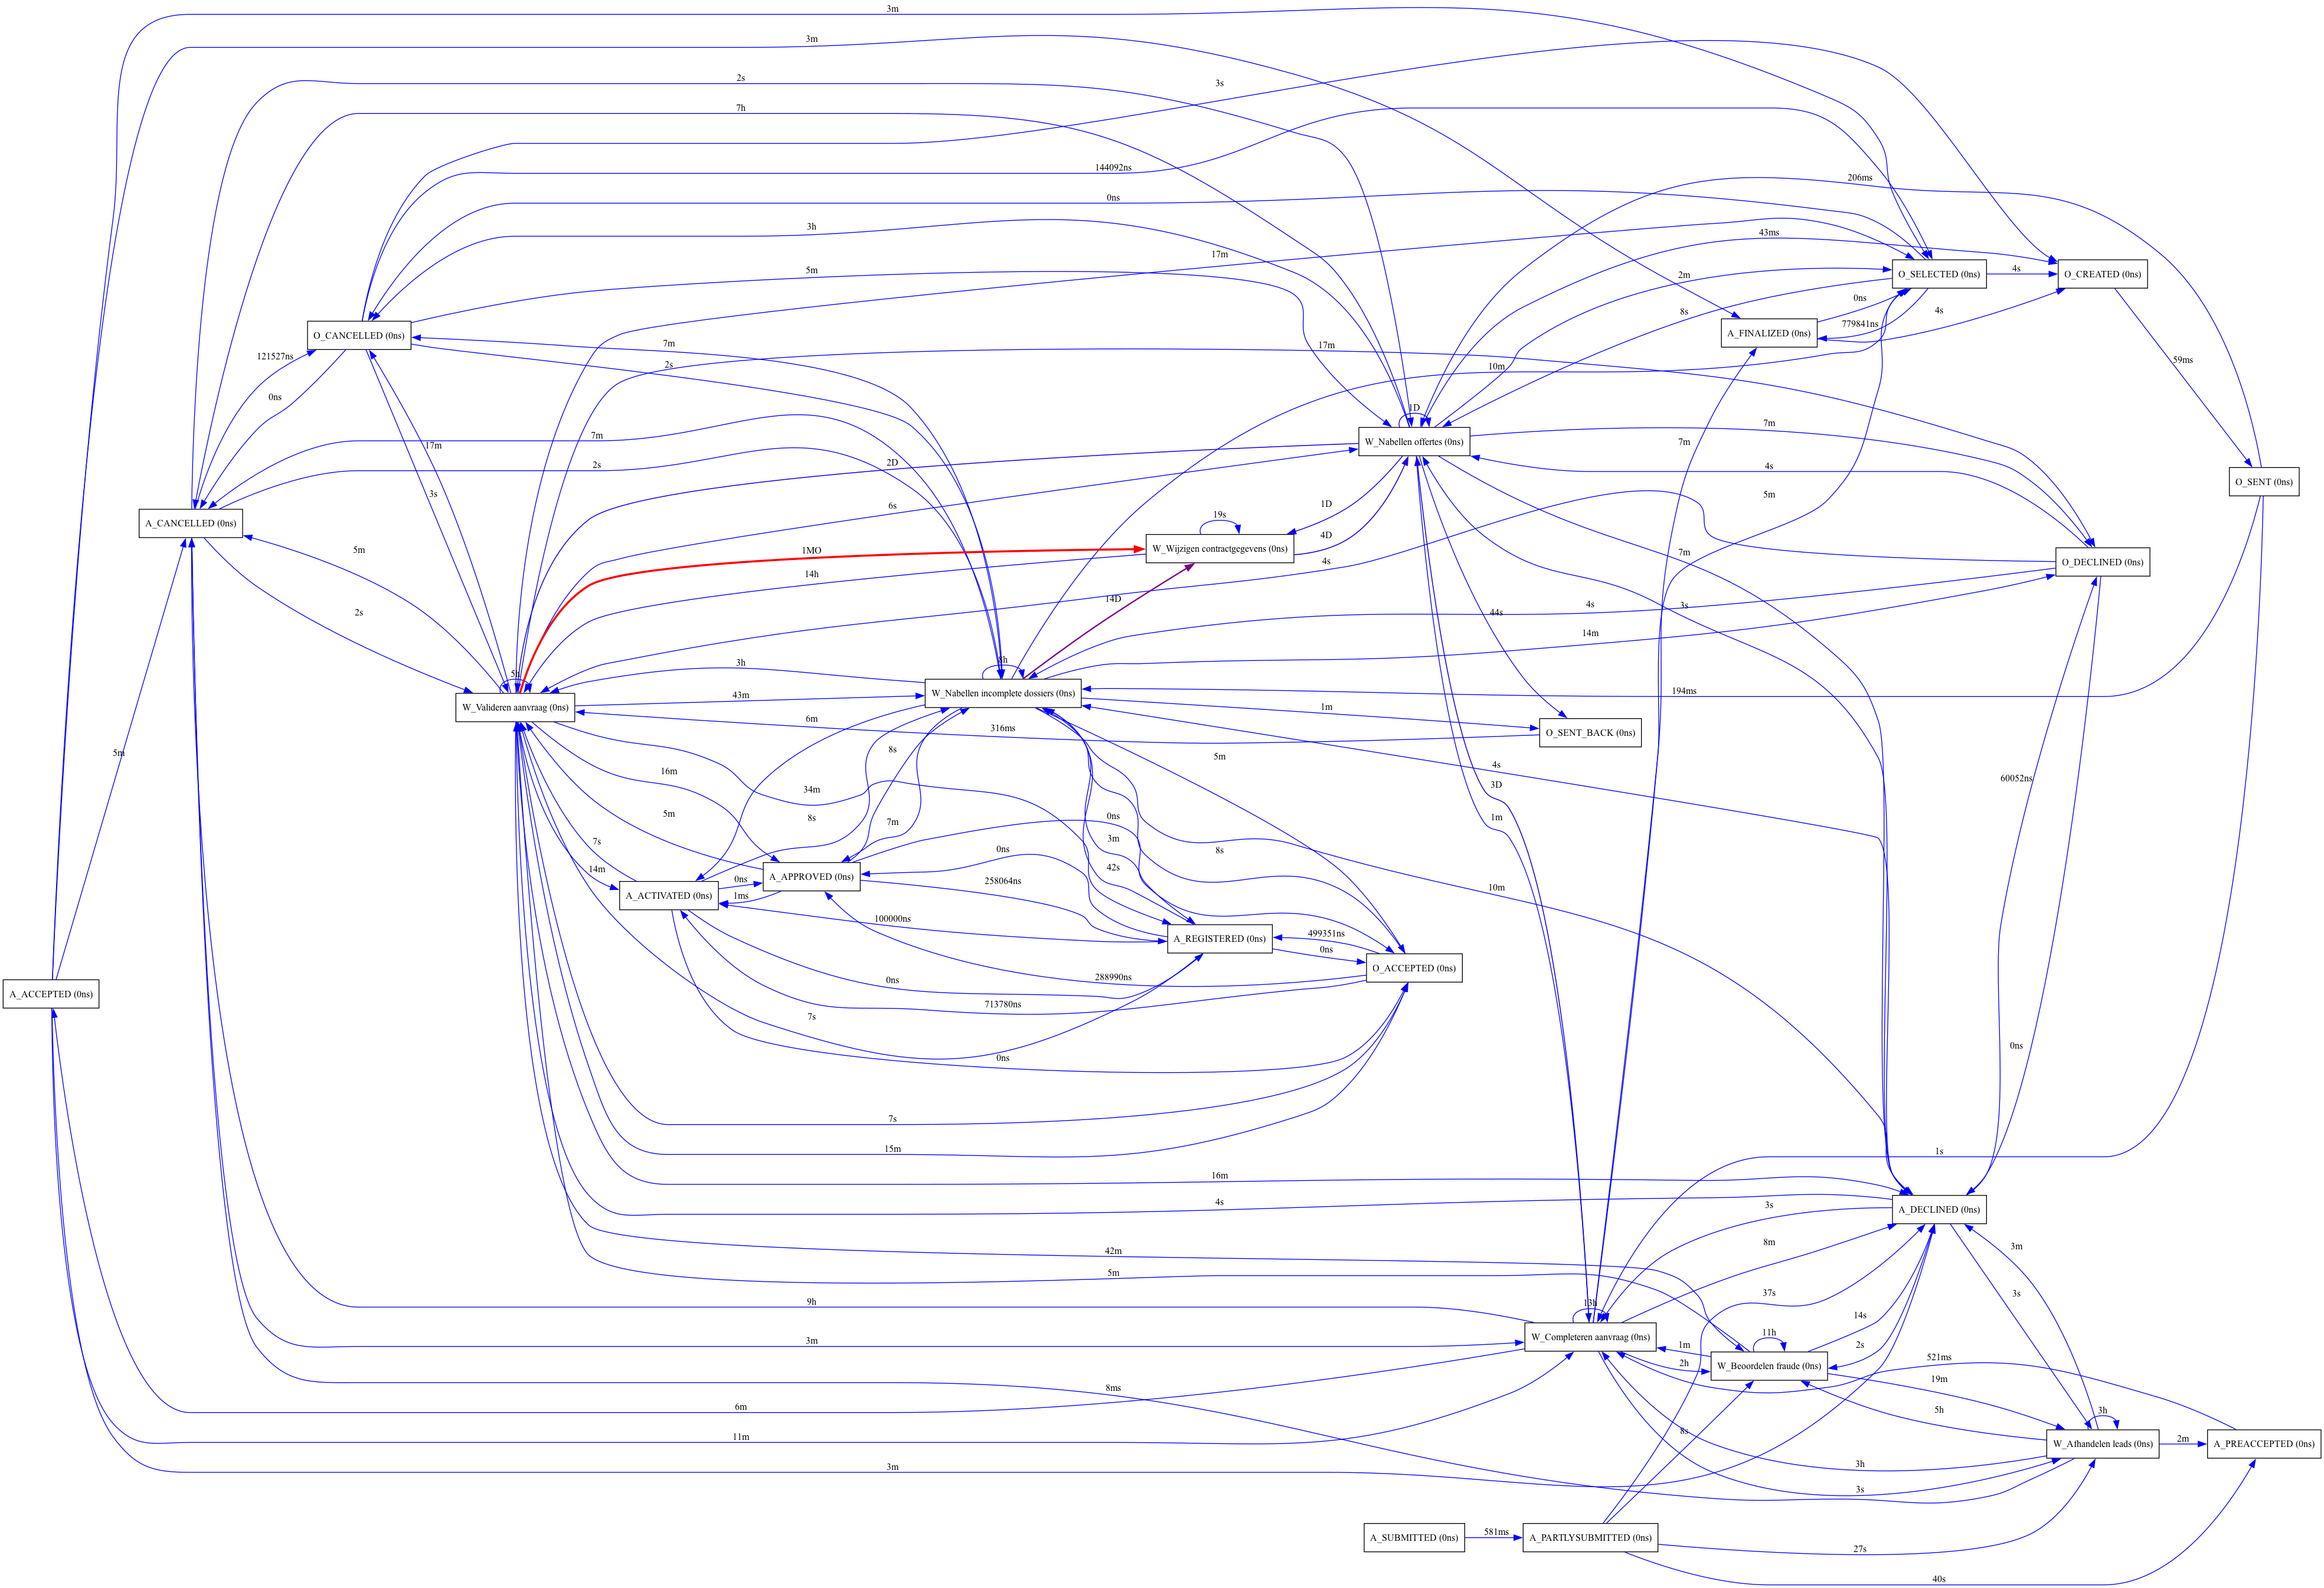

In [52]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# Discover DFG with performance information
dfg_perf = dfg_discovery.apply(event_log, variant=dfg_discovery.Variants.PERFORMANCE)

# Visualize DFG with performance overlay
gviz = dfg_visualizer.apply(dfg_perf, log=event_log, variant=dfg_visualizer.Variants.PERFORMANCE)
dfg_visualizer.view(gviz)


The chart above visualizes the **Directly-Follows Graph (DFG) with performance overlay** using PM4Py. It combines structure and timing insights into one process map.

---

#### What It Shows:
- **Nodes:** Process activities (e.g., `A_SUBMITTED`, `W_Afhandelen leads`).
- **Arrows:**  
  - **Thickness:** Frequency of the transition.  
  - **Color:**  
    - Blue = Standard waiting times.  
    - Red = Above-average delays.
  - **Labels:** Median waiting time between activities (e.g., `3h`, `2 days`).

---

#### Key Insights:
- **Start and End:** Process always starts with `A_SUBMITTED` → `A_PARTLYSUBMITTED`.  
- **Bottlenecks:** Red arrows highlight slow transitions, such as `W_Afhandelen leads` → `W_Valideren aanvraag`.  
- **Loops/Rework:** Frequent around `W_Nabellen offertes` and `W_Nabellen incomplete dossiers`.  
- **Time Patterns:** Fast transitions for simple steps, longer delays before validation and lead handling.

---

#### Why It’s Useful:
- Combines frequency and performance insights visually.  
- Quickly identifies delays and process inefficiencies.  
- Complements formal models like Petri Nets by focusing on **timing, not compliance**.

> **Summary:**  
> A focused, business-friendly visualization to spot bottlenecks, rework, and slow segments in the loan application process.

### 6.5 Bottleneck Identification

In [91]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# Discover DFG with performance information
dfg_perf = dfg_discovery.apply(event_log, variant=dfg_discovery.Variants.PERFORMANCE)

# dfg_perf is a dictionary: { (activity_from, activity_to): median_waiting_time_in_seconds }


dfg_perf_df = pd.DataFrame([
    {'from': k[0], 'to': k[1], 'median_waiting_time_seconds': v}
    for k, v in dfg_perf.items()
])

# Sort by longest waiting time
dfg_perf_df_sorted = dfg_perf_df.sort_values(by='median_waiting_time_seconds', ascending=False)

# Show top 10 bottlenecks
dfg_perf_df_sorted.head(10)


from                           to  \
33             W_Valideren aanvraag  W_Wijzigen contractgegevens   
120  W_Nabellen incomplete dossiers  W_Wijzigen contractgegevens   
118     W_Wijzigen contractgegevens          W_Nabellen offertes   
11           W_Completeren aanvraag          W_Nabellen offertes   
16              W_Nabellen offertes         W_Valideren aanvraag   
106             W_Nabellen offertes  W_Wijzigen contractgegevens   
12              W_Nabellen offertes          W_Nabellen offertes   
107     W_Wijzigen contractgegevens         W_Valideren aanvraag   
3            W_Completeren aanvraag       W_Completeren aanvraag   
71              W_Beoordelen fraude          W_Beoordelen fraude   

     median_waiting_time_seconds  
33                  2.650362e+06  
120                 1.223509e+06  
118                 3.524428e+05  
11                  2.675056e+05  
16                  2.232963e+05  
106                 1.703864e+05  
12                  1.353216e+05  
107                 5.065143e+04  
3                   4.735303e+04  
71                  4.065035e+04

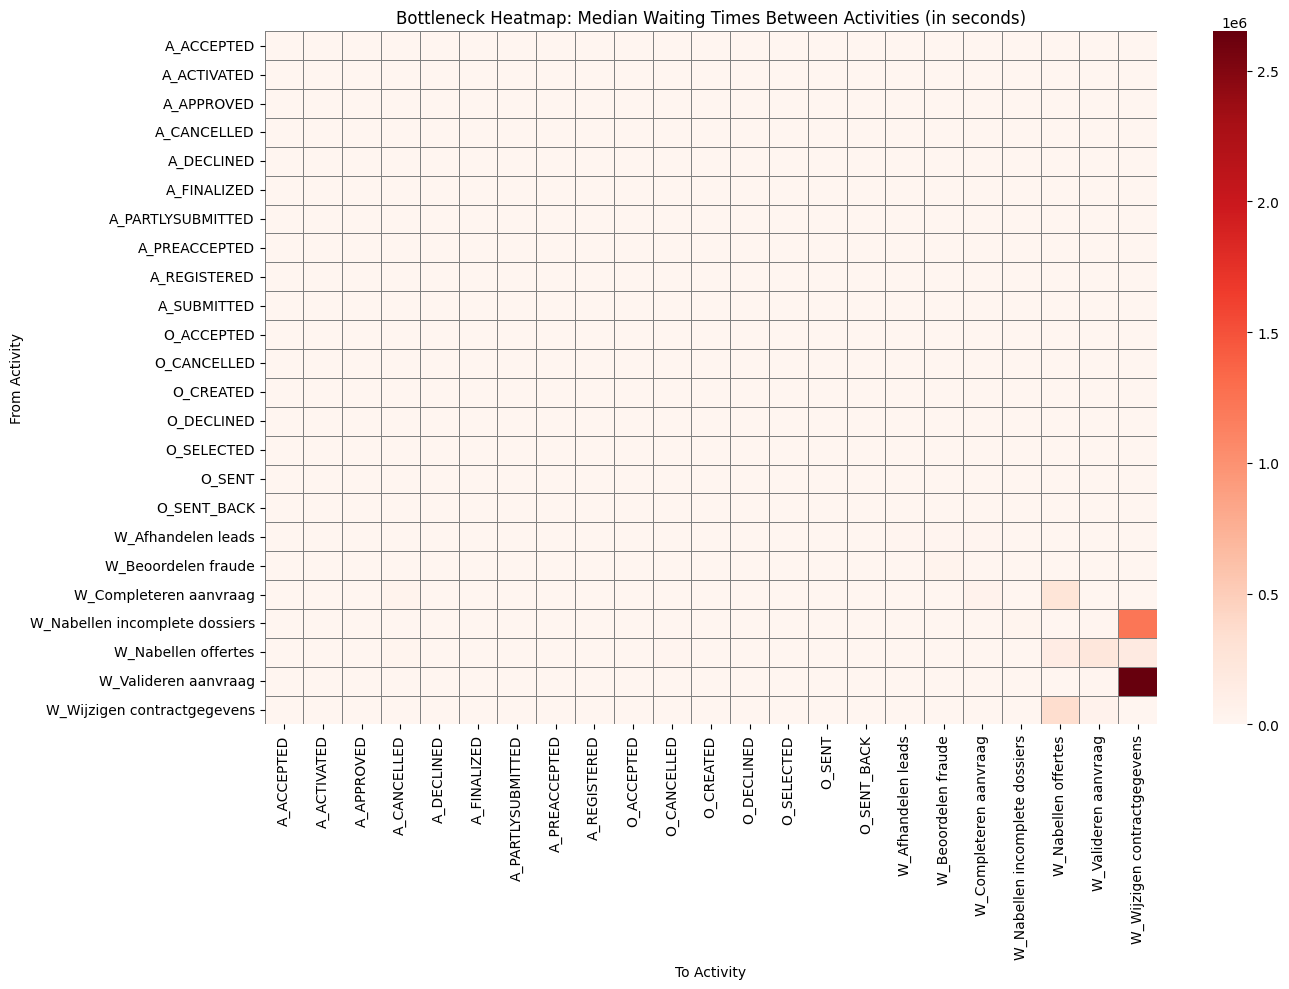

In [101]:
# Prepare data for heatmap: pivot the DataFrame into a matrix
dfg_perf_pivot = dfg_perf_df.pivot(index='from', columns='to', values='median_waiting_time_seconds').fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(dfg_perf_pivot, annot=False, cmap="Reds", linewidths=0.5, linecolor='gray')

plt.title("Bottleneck Heatmap: Median Waiting Times Between Activities (in seconds)")
plt.xlabel("To Activity")
plt.ylabel("From Activity")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 6.6 Actionable Suggestiongs
- Cycle Time Ranges: From the cycle time distribution, identify the typical duration range.
- Common Delays: Pinpoint which activity transitions show the longest delays.

Proposed process changes:
- Automating long manual steps.
- Reducing hand-offs between departments.

## 7. Variant and Frequency Analysis

### 7.1 Purpose of Variant and Frequency Analysis

In real-life processes, not all cases follow the same path.  
**Variant analysis** shows:

- How many unique process paths exist.
- Which paths (variants) occur most frequently.
- Where rare or unexpected behavior occurs.

This helps identify optimization opportunities and process standardization issues.


### 7.2 Extract and Analyze Variants Using PM4Py

PM4Py provides built-in functions to extract process variants:

In [56]:
from pm4py.statistics.traces.generic.log import case_statistics

# Extract variants and their frequencies
variants_count = case_statistics.get_variant_statistics(event_log)

# Sort variants by frequency
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

# Display top 5 variants
for variant in variants_count[:5]:
    print(f"Variant: {variant['variant']}")
    print(f"Frequency: {variant['count']}")
    print("---")


Variant: ('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED')
Frequency: 3429
---
Variant: ('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads')
Frequency: 1872
---
Variant: ('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads')
Frequency: 271
---
Variant: ('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_PREACCEPTED', 'W_Completeren aanvraag', 'W_Afhandelen leads', 'W_Completeren aanvraag', 'A_DECLINED', 'W_Completeren aanvraag')
Frequency: 209
---
Variant: ('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'W_Completeren aanvraag', 'W_Completeren aanvraag', 'A_DECLINED', 'W_Completeren aanvraag')
Frequency: 160
---


/var/folders/xf/4sdwstz12kv6j1twjsxj9dz80000gn/T/ipykernel_86030/2792271877.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="variant_str", data=top_variants, palette="viridis")


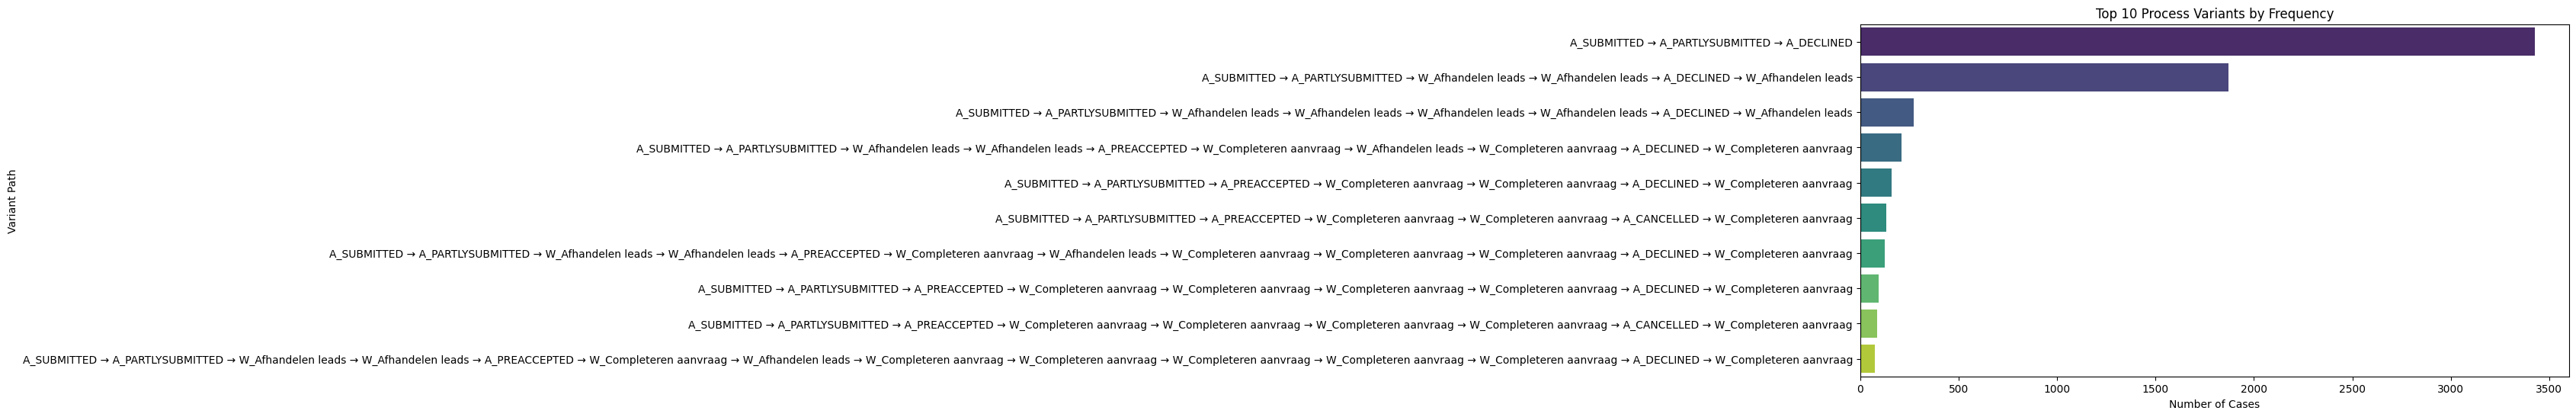

In [58]:
# Flatten 'variant' from tuple/list to a string
variant_df['variant_str'] = variant_df['variant'].apply(lambda x: ' → '.join(x))

# Keep only top 10 variants for clarity
top_variants = variant_df.head(10)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="variant_str", data=top_variants, palette="viridis")
plt.title("Top 10 Process Variants by Frequency")
plt.xlabel("Number of Cases")
plt.ylabel("Variant Path")
plt.show()


Interpretation of Number of Variants:
- High-Frequency Variants: Represent the "happy path" or standard operating procedure.
- Rare Variants: Indicate exceptions, special cases, or process deviations.

Reflection:
- Are the most frequent variants aligned with expected business processes?
- Should rare variants be reduced or managed differently (e.g., through automation or policy changes)?

- **Two Dominant Variants:**  
  - **Most frequent:** `A_SUBMITTED → A_PARTLYSUBMITTED → A_DECLINED`  
  - **Second most frequent:** Includes `W_Afhandelen leads` repetitions before `A_DECLINED`.  
  ✅ Both reflect early rejection or withdrawal, often without completing full validation or approval steps.

- **Recurring Patterns in Mid/Low Variants:**  
  - Many mid-frequency variants involve repeated `W_Completeren aanvraag` or `W_Afhandelen leads`.  
  ✅ These highlight rework loops or delays caused by incomplete information or lead management steps.

- **Business Implications:**  
  - High rejection rate early in the process suggests optimization potential in lead qualification or customer onboarding.  
  - Repeated tasks point to areas where automation or clearer instructions could reduce processing time and manual follow-up.

---

> **Summary:**  
> The top process variants emphasize that most applications either terminate early or repeat information collection steps. Addressing these patterns can improve both process efficiency and customer experience.

## 8. Conformance Checking
- High Fitness: Indicates process execution closely follows documented procedures.
- Low Fitness: Suggests process deviations or flexibility.
- Actionable Insight: Investigate why deviations happen—business exceptions, system issues, or deliberate flexibility?

### 8.1 Purpose of Conformance Checking

Conformance checking helps answer:  
**"How well does the observed process match the expected or reference model?"**

In this step, we’ll compare real process behavior against a Petri net model derived from Inductive Miner.


### 8.2 Method Used: Token-Based Replay

**Why Token-Based Replay?**
- It’s the most commonly used conformance technique supported in PM4Py.
- Measures:
  - **Fitness:** How many cases fit the model without deviations.
  - **Missing/Consumed Tokens:** Where the process deviated from the model.


### 8.3 Apply Token-Based Replay in PM4Py
- trace_is_fit: True or False
- missing_tokens: Tokens needed but missing in the log
- consumed_tokens: Tokens actually used

In [59]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# Apply Token-Based Replay on event log and Petri Net
replayed_traces = token_replay.apply(event_log, net, initial_marking, final_marking)

# Display sample results
for trace in replayed_traces[:5]:
    print(trace)

replaying log with TBR, completed traces ::   0%|          | 0/4366 [00:00<?, ?it/s]

{'trace_is_fit': False, 'trace_fitness': 0.9715639810426541, 'activated_transitions': [(139aacb6-b706-43b5-88e4-fc0a1477e759, 'A_SUBMITTED'), (aca1e773-dccc-4b58-882f-a74cca228807, 'A_PARTLYSUBMITTED'), (566c7a4c-6ff8-431e-8084-16e137c62589, 'A_PREACCEPTED'), (tauSplit_6, None), (init_loop_9, None), (17b37b7b-ba2d-49e6-a5cb-ea19a963bf53, 'W_Completeren aanvraag'), (skip_11, None), (17b37b7b-ba2d-49e6-a5cb-ea19a963bf53, 'W_Completeren aanvraag'), (c69fb915-da6d-4a02-b94e-0a7d8f8b4338, 'A_ACCEPTED'), (tauSplit_16, None), (init_loop_19, None), (4bddff82-94be-48b3-ab89-ac1c5acec772, 'O_SELECTED'), (1745968b-99f5-42fc-95c8-1d1ebc5a3c40, 'A_FINALIZED'), (init_loop_24, None), (e80a146c-11a2-41d3-8d7c-c81fedbf2617, 'O_CREATED'), (30d95cef-6feb-4077-80eb-ddcb5197940e, 'O_SENT'), (tauSplit_28, None), (tauSplit_37, None), (tauSplit_49, None), (1473f71c-7020-40ad-b645-1fb33e14379e, 'W_Nabellen offertes'), (skip_11, None), (17b37b7b-ba2d-49e6-a5cb-ea19a963bf53, 'W_Completeren aanvraag'), (skip_30, 

#### 8.3.1 Token Replay Summary

- **Fitness:** Most traces show fitness between 0.96–1.0. High alignment overall.
- **Deviations:** Main issue: `W_Nabellen offertes` — frequently in `transitions_with_problems`, likely due to unmodeled repetitions or optional behavior.
- **Token Statistics:**  
  - Missing tokens: 6–25 per non-fitting trace.  
  - Consumed tokens: up to 707.  
  - Remaining tokens: similar to missing, suggesting leftover tokens rather than loss.  
- **Non-Fitting Patterns:**  
  - Loops around `W_Nabellen offertes` and `W_Completeren aanvraag` dominate misalignments.  
  - Some traces leave tokens in intermediate places, showing incomplete subprocesses.
- **Fit Traces:**  
  - Simple sequences like `A_SUBMITTED → A_PARTLYSUBMITTED → A_DECLINED` show perfect fit.
- **Insights:**  
  - High fitness overall, but loops and repetitive follow-ups cause conformance gaps.  
  - Model refinement could focus on better representing repetitive tasks or using calibration techniques.  
  - Business recommendation: Review process steps with frequent repetitions or manual interventions.

#### 8.3.2 Simplified Summary Example:

In [60]:
fit_traces = [trace for trace in replayed_traces if trace['trace_is_fit']]
not_fit_traces = [trace for trace in replayed_traces if not trace['trace_is_fit']]

print(f"Number of fitting traces: {len(fit_traces)}")
print(f"Number of non-fitting traces: {len(not_fit_traces)}")
print(f"Percentage of fitting traces: {len(fit_traces) / len(replayed_traces) * 100:.2f}%")


Number of fitting traces: 8076
Number of non-fitting traces: 5011
Percentage of fitting traces: 61.71%


### 8.4 Conformance Issues per Transistion

/var/folders/xf/4sdwstz12kv6j1twjsxj9dz80000gn/T/ipykernel_86030/1268921882.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=problem_df, x='problem_count', y='transition', palette='Reds')


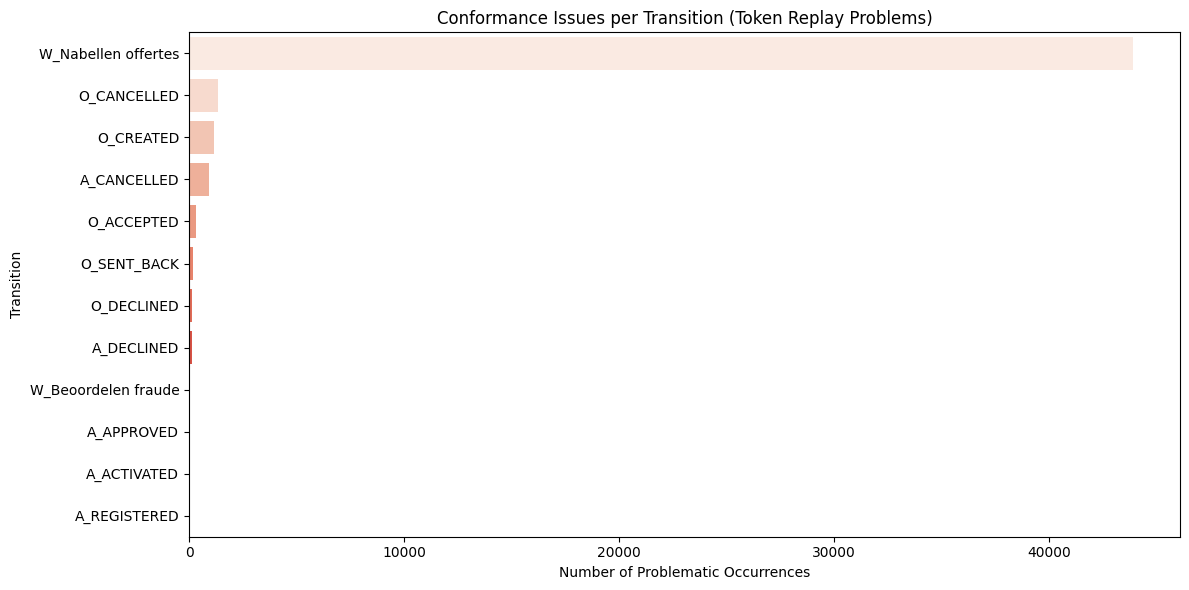

In [103]:
# Step 1: Count problems per transition using object attributes
transition_problem_counter = Counter()

for trace in replayed_traces:
    for transition in trace['transitions_with_problems']:
        transition_name = transition.label if transition.label else str(transition.name)
        transition_problem_counter[transition_name] += 1

# Step 2: Create DataFrame
problem_df = pd.DataFrame.from_dict(transition_problem_counter, orient='index', columns=['problem_count']).reset_index()
problem_df.rename(columns={'index': 'transition'}, inplace=True)
problem_df = problem_df.sort_values(by='problem_count', ascending=False)

# Step 3: Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=problem_df, x='problem_count', y='transition', palette='Reds')
plt.title("Conformance Issues per Transition (Token Replay Problems)")
plt.xlabel("Number of Problematic Occurrences")
plt.ylabel("Transition")
plt.tight_layout()
plt.show()

### 9. Business Recommendations

### 9.1 Suggested  Actions

| Observation                 | Suggested Action                          |
|----------------------------|------------------------------------------|
| High variation in variants | Standardize process flows where possible |
| Long cycle times in some cases | Automate slow steps or review policies      |
| Bottlenecks identified      | Reassign resources or review handover rules |
| Process deviations          | Update documentation or implement stricter controls |

### 9.2 Case Study Summary

| Metric                     | Value                               |
|---------------------------|-------------------------------------|
| Unique Variants           | X                                   |
| Median Case Duration      | Y hours/days                        |
| Maximum Case Duration      | Y hours/days                        |
| Top Bottleneck Transition | `Activity A → Activity B`           |
| Conformance Fitness Rate  | W%                                  |
| Deviations observed  | X out of Y cases                                  |

### 9.3 Suggested Next steps

- Integration with real-time monitoring dashboards.
- Continuous conformance checking using scheduled data refresh.
- Expanding analysis scope to cover other processes (e.g., Order-to-Cash).
